# Subreddit Predictor

The purpose of this project is to create a Machine Learning Model which can read a reddit post title and predict which subreddit it belongs to. The project will be broken up into steps which can be separated into three main sections.

### First Look
1: Identify the Problem and Goal
2: Aquire the Data
3: Analyze the Data
4: Naive Model
5: Speculate on Model Improvements

### Systematic Approach
6: Create New Models
7: Compare and Analyze Results
8: Choose a "Winning" Model

### Optimization
9: optimize the Winning Model
10: Analyze Final Results
11: Suggest Future Improvements

# 1: Identify the Problem and Goal

The purpose of this project is to create a Machine Learning model which can read a reddit post title and predict which subreddit it belongs to. For simplicity we will train the model only to distinguish between a small number of subreddits. These subreddits are chosen to have a wide variety of post titles. Some subreddits will be trivial for the model, such as r/AmITheAsshole in which every post contains the word "AITA" or "WIBTA", abriviations for "Am I the asshole" and "Would I be the asshole" respectively. Other subreddits such as r/Awww and r/pics have post titles which contain very little information and thus will most likely be hard to distinguish.

In [520]:
top_subreddits = ['announcements', 'funny', 'AskReddit', 'dataisbeautiful', 'Awww', 'datascience', 'pics', 'science', 'worldnews', 'videos', 'AmItheAsshole']

### Metrics

The overall metric for each model will be Accuracy = Correct_Classifiactions/All_Classifications. However we expect any model will preform differently on different subreddits. So we want to measure the contrubution to the accuracy score from each subreddit. Fortunately this coincides with the Recall = True_Positives/(True_Positives + False_Negatives) when the saize of each categories are the same.



# 2: Aquire the Data

Reddit data is usually gathered through an API and by using the wrapper "praw". For larger amounts of data, or for historical data we can use PushShift and it's wrapper "psaw". Unfortunately, PushShift is down right now so we will have to stick with "praw". This limits the amount of data we can gather. We will limit ourselves to the last 1000 posts on each subreddit.

In [42]:
import praw
import secrets

user_agent = "Subreddit-Predictor 0.2 by /u/IsThisATrollBot"

reddit = praw.Reddit(
    client_id=secrets.client_ID,
    client_secret=secrets.client_secret,
    password=secrets.password,
    user_agent=user_agent,
    username=secrets.username,
)

In [73]:
# Create an empty list to store the posts
posts = []

# Iterate through the subreddits and get the last 1000 posts from each
for sub in top_subreddits:
    subreddit_posts = reddit.subreddit(sub).new(limit=1000)
    for post in subreddit_posts:
        posts.append(post)

In [74]:
import pandas as pd

# Create a list of dictionaries containing the data for each post
data = [{'id': post.id, 'title': post.title, 'subreddit': post.subreddit.display_name} for post in posts]

# Create a Pandas dataframe from the list of dictionaries
df_raw = pd.DataFrame(data)
df_raw = df_raw.set_index('id')

# 3: Analyze the Data

Let's first read through a couple entries, then clear out all of the empty and duplicate rows. After that we are going to examine a large number of entries and see if we can classify them **by hand**. This will give us a good benchmark on how difficult the problem is. It will also give incite into which features will be most useful.

In [75]:
df_raw

,title,subreddit
id,,
t93ec3,This subreddit is closed for new posts and com...,announcements
pg006s,COVID denialism and policy clarifications,announcements
pbmy5y,"Debate, dissent, and protest on Reddit",announcements
nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements
mi01fg,Second,announcements
...,...,...
10hudso,AITA for not wanting my sister to use my winte...,AmItheAsshole
10hu8h2,AITA for telling my recently adopted sister th...,AmItheAsshole
10hty0b,AITA for guy leaving our local gym and possibl...,AmItheAsshole


## Remove Empty and Repeated entires

In [94]:
df = df_raw.copy()

# Remove empty rows
df['title'] = df['title'].str.strip()
filter = df['title'] == ''
print(len(df[filter]))
df = df.drop(df[filter].index)

0


In [95]:
# Find any duplicates
df[df.duplicated(keep = False)]

,title,subreddit
id,,
c0gmy,"We are aware that reddit appears hung over, an...",announcements
c0gl6,"We are aware that reddit appears hung over, an...",announcements
10kfesb,What improved your quality of life so much you...,AskReddit
10kectz,Why are you here?,AskReddit
10kdwxu,What improved your quality of life so much you...,AskReddit
...,...,...
10jado2,"January 22, 2023",videos
10j7mik,THE LAST OF US EPISODE 2 REACTION- 1x2 Review ...,videos
10j7i6b,Cat Man against the Black Dragon Ninjas,videos


In [96]:
# Drop the duplicates
filter = df.duplicated()
df = df[~filter]
df

,title,subreddit
id,,
t93ec3,This subreddit is closed for new posts and com...,announcements
pg006s,COVID denialism and policy clarifications,announcements
pbmy5y,"Debate, dissent, and protest on Reddit",announcements
nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements
mi01fg,Second,announcements
...,...,...
10hudso,AITA for not wanting my sister to use my winte...,AmItheAsshole
10hu8h2,AITA for telling my recently adopted sister th...,AmItheAsshole
10hty0b,AITA for guy leaving our local gym and possibl...,AmItheAsshole


### Load the Human Data

I have already examined the data and attempted to assign to each post title a subreddit from the list of top_subreddits. The data set I looked at consisted of 20 random samples from each subreddit, so 220 samples in total. I also wrote down the explanation of each decision to gather further insight.

In [513]:
human = pd.read_csv('human.csv')
human = human.set_index('id')
human

,title,actual,prediction,explanation
id,,,,
10jo7ai,Why Thou At The Airport,videos,videos,asks a question in a weird way
10dxjxk,"""Did I promise to show you lovely patients? Lo...",Awww,Awww,"""lovely"" and ""look"""
3p4shh,CEO Steve here to answer more questions.,announcements,announcements,sounds like buisness stuff
10jpv7y,Saw this on an old mini van's windows there we...,pics,funny,referencing a picture that might be funny
10gy5x1,UK shop sales fell by record numbers both in D...,worldnews,worldnews,sounds like news
...,...,...,...,...
cskdl,"Welcome, Jeff!",announcements,funny,probably a funny picture
10i2tcg,Random click,pics,funny,probably a funny pic or video
10jqv4f,Serbia May Lose Chance to Join EU If It Reject...,worldnews,worldnews,countries


Even without doing an indepth analysis a few things are immediatly clear:
- Certain "key words" belong exclusively to certain subreddits. These words are ['aita', 'wibta', '[oc]', '[serious]', 'data scientist']. More words probably exist.
- If the post asks a question, it is usually either AskReddit or datascience. Specific questions are datascience and general ones are AskReddit.
- r/science has a lot of science-y words.
- r/worldnews has long titles and usually contains country names
- "cute" words like ['puppy', 'baby', '<3'] indicate r/Awww
- A lot of the subreddits were distinguished by what topic the post titles were talking about. This probably means a pre-trained Word2Vec model (maybe averaging word vectors) could be useful.
- Emojis and shorter titles are more appropriate in r/Awww and r/funny
- r/videos is very difficult to deal with.

Let's now do an analysis to show the recall score for each subreddit category.

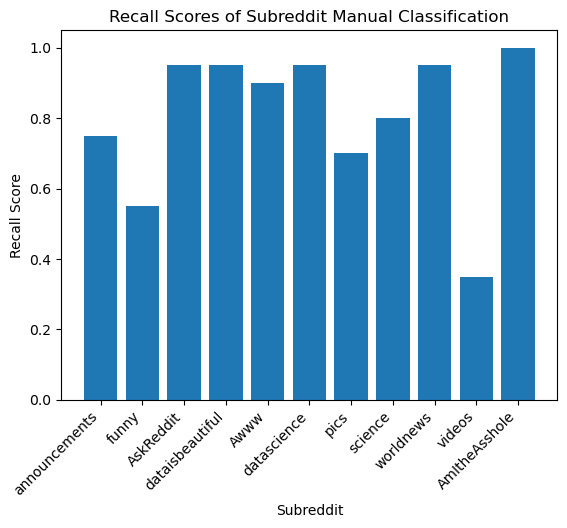

In [604]:
human_prediction_data = pd.DataFrame(columns=['value'])
human_bar_data = {}
for sub in top_subreddits:
    filter1 = human['actual'] == sub
    filter2 = human['actual'] == human['prediction']
    #human_prediction_data.loc[sub] = len(human[filter1 & filter2])/20
    human_bar_data[sub] = len(human[filter1 & filter2])/20

# Plot a bar chart
fig, ax = plt.subplots()
#ax.bar(human_prediction_data.index, human_prediction_data['value'])
ax.bar(human_bar_data.keys(), human_bar_data.values())

#plt.bar(human_prediction_data.index, human_prediction_data['value'])

# Rotate the labels on the x-axis by 45 degrees
plt.xticks( rotation=45, ha='right')
plt.xlabel("Subreddit")
plt.ylabel("Recall Score")
plt.title("Recall Scores of Subreddit Manual Classification")
# Show the plot

#mean_value = human_prediction_data['value'].sum()/11
#ax.axhline(y=mean_value, color='r', linestyle='--')

plt.show()



Seeing the actual recall scores confirms the initial assessment

## Preliminary Feature Analysis

We're now going to analyize a few features to confirm that they will actually be useful in classification.

## Length of Post

How much does the length of a post title tell us about the subreddit? To answer this question we will create a line graph with a serperate line for each subreddit. The x-axis is the length of the post and the y-axis is the percentage of all the subreddit post titles that are of that length (so the total area under each curve should be 1). If a specific line is visible at a certain x value, then this tells us post titles of that length will be more or less likely to come from that specific subreddit.

We will create theis graph using two different ways of computing length: number of words and number of characters.

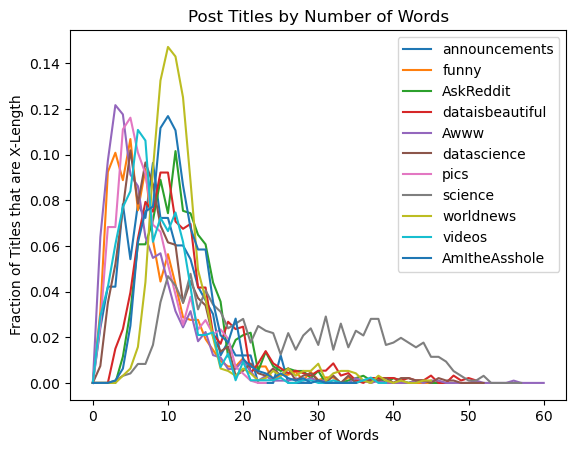

In [522]:
import matplotlib.pyplot as plt

# Initialize an empty dictionary to store the data
data = {}

# Iterate over the top_subreddits
for subreddit in top_subreddits:
    # Get the titles for the subreddit
    titles = df_raw[df_raw['subreddit'] == subreddit]['title']
    # Get the number of words in the titles
    num_words = [len(title.split()) for title in titles]
    # Get the percentage of titles for the subreddit with a specific number of words
    percentages = []
    for i in range(max(num_words)):
        percentages.append(num_words.count(i)/len(num_words))
    # Add the data to the dictionary
    data[subreddit] = percentages

# Plot the data
for subreddit, percentages in data.items():
    plt.plot(range(len(percentages)), percentages, label=subreddit)

# Add labels and title
plt.xlabel("Number of Words")
plt.ylabel("Fraction of Titles that are X-Length")
plt.title("Post Titles by Number of Words")
plt.legend()

# Show
plt.show()

The length of a post doesn't seem to tell us too much. Longer posts are usually in r/science. The posts in r/worldnews peak around 11 words, probably because they are all news headlines.

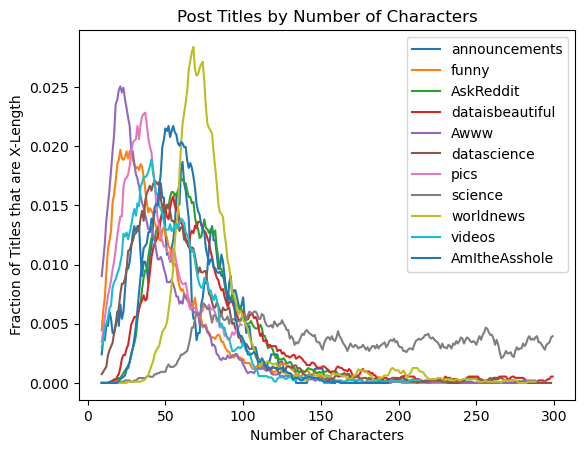

In [523]:
# Define the window size for the moving average
window_size = 10

# Initialize an empty dictionary to store the data
data = {}

# Iterate over the top_subreddits
for subreddit in top_subreddits:
    # Get the titles for the subreddit
    titles = df_raw[df_raw['subreddit'] == subreddit]['title']
    # Get the number of characters in the titles
    num_chars = [len(title) for title in titles]
    # Get the percentage of titles for the subreddit with a specific number of characters
    percentages = []
    for i in range(max(num_chars)):
        percentages.append(num_chars.count(i)/len(num_chars))
    # Apply moving average
    percentages_smooth = pd.Series(percentages).rolling(window_size).mean()
    # Add the data to the dictionary
    data[subreddit] = percentages_smooth

# Plot the data
for subreddit, percentages in data.items():
    plt.plot(range(len(percentages)), percentages, label=subreddit)

# Add labels and title
plt.xlabel("Number of Characters")
plt.ylabel("Fraction of Titles that are X-Length")
plt.title("Post Titles by Number of Characters")
plt.legend()

# Show
plt.show()


Looking at the same graph for character length is a little bit more revealing, but not much.

## Contains Specific Expressions

Let's look at specific expressions such as "aita", "data", "[oc]", and "?" to see what they tell us about the specific subreddit.
We can also check to see if there are emojis.

Let's now find a list of all the words used more than 100 times. And we'll do the same key_words thing

In [538]:
from collections import Counter

# Create a list of all words in the title column
lower_df = df.copy()
lower_df['title'] = lower_df['title'].apply(lambda x: x.lower())

all_words = ' '.join(lower_df['title']).split()
# Create a Counter object to count the occurrences of each word
word_count = Counter(all_words)
# Create a list of words that appear more than 100 times
frequent_words = [word for word, count in word_count.items() if count > 100]
# Print the list of frequent words
print(frequent_words)



['this', 'is', 'for', 'new', 'and', 'to', 'the', 'on', 'an', 'a', 'you', 'can', 'with', 'our', 'from', 'who', 'into', 'how', 'your', 'some', 'have', 'of', 'i', 'us', 'are', 'we', 'had', 'what', 'as', 'in', 'about', 'more', 'people', 'will', 'like', 'has', 'not', 'my', 'could', 'be', 'it', 'so', 'was', 'but', 'time', 'all', 'that', 'year', 'just', 'out', 'their', 'up', 'by', 'why', 'at', '-', 'when', "what's", 'data', 'than', 'if', 'over', 'do', 'me', 'would', 'did', 'friend', 'first', 'found', 'they', 'were', 'made', 'her', 'he', 'best', 'after', 'one', 'years', 'or', 'his', 'most', '[oc]', 'she', '|', 'study', 'science', 'telling', 'get', '&', 'world', '2022', 'ukraine', 'aita', 'wibta']


In [539]:
conditions = {}

def contains(key):
    def foo(sentence):
        return (key in sentence.split())

    return foo


def add_contains_key(key):
    conditions['contains "' + key + '"'] = contains(key)


for key in frequent_words:
    add_contains_key(key)

table = pd.DataFrame(columns=['Condition', '% Correct', 'Total Affected'])

for key, val in conditions.items():
    filter = lower_df['title'].apply(val)
    temp_df = lower_df[filter]
    total = len(temp_df)
    if total == 0: break

    cor = []
    for subreddit in top_subreddits:
        cor.append(len(temp_df[temp_df['subreddit'] == subreddit]) / total)

    correct_percent = max(cor)

    table = pd.concat(
        [table, pd.DataFrame({'Condition': [key], '% Correct': [correct_percent], 'Total Affected': [total]})],
        ignore_index=True)

table

,Condition,% Correct,Total Affected
0,"contains ""this""",0.246753,462
1,"contains ""is""",0.296433,813
2,"contains ""for""",0.471916,1816
3,"contains ""new""",0.360231,347
4,"contains ""and""",0.341516,1385
...,...,...,...
89,"contains ""world""",0.508197,122
90,"contains ""2022""",0.783784,148
91,"contains ""ukraine""",0.932432,148
92,"contains ""aita""",1.000000,826


Remember that there are 11 subreddits to choose from, so any guess better than 10% is still good.
This tells me that a simple Bag-of-Words algorithm will probably not do too bad.

Let's also see if specific characters can be useful in determining which subreddit a post title belongs to.


In [546]:
# Create a list of all characters in the title column


all_characters = ''.join(df['title'])
total_chars = len(all_characters)

In [556]:

# Create a Counter object to count the occurrences of each word
character_count = Counter(all_characters)
# Create a list of words that appear more than 100 times
infrequent_chars = [char for char, count in character_count.items() if ((count < total_chars/100) & (count > 10))]
# Print the list of frequent words
print(infrequent_chars)

['T', 'b', '.', 'F', ',', 'R', 'I', 'v', '/', 'C', 'O', 'V', 'D', 'S', 'G', 'A', '’', '(', ')', 'N', 'k', 'U', 'P', '—', '1', '0', '%', '-', '9', 'W', 'H', 'M', 'x', 'L', '…', '2', 'E', "'", '!', '3', 'B', ':', 'z', 'q', '8', 'Y', 'Q', '?', 'J', '7', 'j', '6', ';', '#', 'K', '"', '5', '█', '[', ']', 'Z', '“', '”', '*', '😂', '&', 'X', '🤣', '|', 'é', '4', '$', '️', '♥', '\u200d', '‘', '+', '=', '–', '😍', '🥰', '❤', '🖤', 'র', 'া']


In [557]:

conditions = {}


def contains(key):
    def foo(sentence):
        return (key in sentence)

    return foo


def add_contains_key(key):
    conditions['contains "' + key + '"'] = contains(key)


for key in infrequent_chars:
    add_contains_key(key)

table = pd.DataFrame(columns=['Condition', '% Correct', 'Total Affected'])

for key, val in conditions.items():
    filter = df['title'].apply(val)
    temp_df =df[filter]
    total = len(temp_df)
    if total == 0: break

    cor = []
    for subreddit in top_subreddits:
        cor.append(len(temp_df[temp_df['subreddit'] == subreddit]) / total)

    correct_percent = max(cor)

    table = pd.concat(
        [table, pd.DataFrame({'Condition': [key], '% Correct': [correct_percent], 'Total Affected': [total]})],
        ignore_index=True)

table

,Condition,% Correct,Total Affected
0,"contains ""T""",0.359070,2668
1,"contains ""b""",0.172974,4122
2,"contains "".""",0.229738,1715
3,"contains ""F""",0.173378,894
4,"contains "",""",0.265607,1762
...,...,...,...
80,"contains ""🥰""",0.958333,24
81,"contains ""❤""",0.906250,32
82,"contains ""🖤""",1.000000,4
83,"contains ""র""",1.000000,2


Surprisingly even a simple character analysis seems like it could be useful in determining which subreddit.

# 4: Naive Solution

The easiest Naive Solution would be to use Bag-of-Words to vectorize each post title, then you a dicision tree based algorithm to classify it.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Split the dataframe into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['subreddit'], test_size=0.2, random_state=)

# Vectorize the post titles using Bag-of-Words
vectorizer = CountVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Train a random forest model to classify each title to its corresponding subreddit
clf = RandomForestClassifier()
clf.fit(X_train_vectors, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_vectors)

In [636]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


naive_results = {}
for sub in top_subreddits:
    naive_results[sub] = []
naive_results['Total'] = []

for i in tqdm(range(20)):

    # Split the dataframe into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(df['title'], df['subreddit'], test_size=0.2, random_state=i)


    # Vectorize the post titles using Bag-of-Words
    vectorizer = CountVectorizer()
    X_train_vectors = vectorizer.fit_transform(X_train)
    X_test_vectors = vectorizer.transform(X_test)

    # Train a random forest model to classify each title to its corresponding subreddit
    clf = RandomForestClassifier()
    clf.fit(X_train_vectors, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test_vectors)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    temp_total = 0
    for sub in top_subreddits:
        naive_results[sub].append(classification_rep[sub]['recall'])
        temp_total+=classification_rep[sub]['recall']
    naive_results['Total'].append(temp_total/len(top_subreddits))


100%|██████████| 20/20 [01:40<00:00,  5.00s/it]


In [640]:
naive_results_mean = {}
naive_results_std = {}
for key, val in naive_results.items():
    naive_results_mean[key] = np.mean(val)
    naive_results_std[key] = np.std(val)
naive_results_95_error = list(map(lambda x: 2*x, naive_results_std.values()))

naive_bar_data = naive_results_mean

human_bar_data = {}
for sub in top_subreddits:
    filter1 = human['actual'] == sub
    filter2 = human['actual'] == human['prediction']
    #human_prediction_data.loc[sub] = len(human[filter1 & filter2])/20
    human_bar_data[sub] = len(human[filter1 & filter2])/20

human_bar_data['Total'] = sum(list(human_bar_data.values()))/len(top_subreddits)


#naive_bar_data = list(naive_results_mean.values())

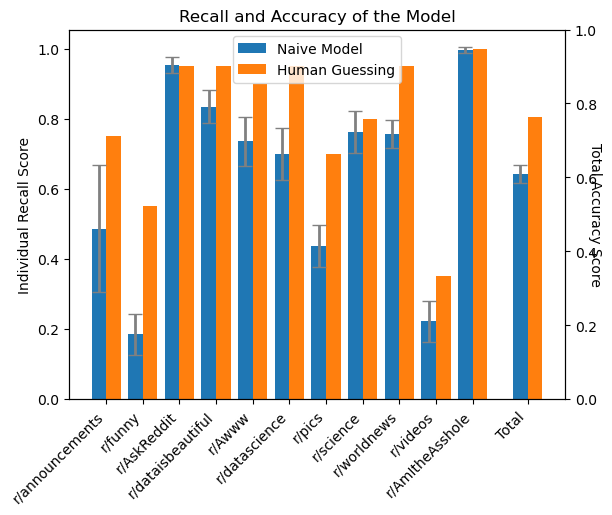

In [641]:
# Create a Bar Chart

categories = list(naive_bar_data.keys())
for i, cat in list(enumerate(categories))[:-1]:
    categories[i] = 'r/'+cat

xticks = list(range(len(categories)))
xticks[-1]+=.5
xticks = np.array(xticks)

bar_width = 0.4

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar(xticks - 0.2, naive_bar_data.values(), bar_width, label = 'Naive Model')
ax1.bar(xticks + 0.2, human_bar_data.values(), bar_width, label = 'Human Guessing')

# Add error bars to the 'Naive Model' set of bars
#Naive_Error = [0.1, 0.15, 0.2, 0.05, 0.1, .1, .3, .05, .2, .1, .11, .15] # Example values
ax1.errorbar(xticks - 0.2, naive_bar_data.values(), yerr=naive_results_95_error, fmt='none', ecolor='gray', elinewidth=2, capsize=5)

ax1.set_xticks(xticks)
ax1.set_xticklabels(categories, rotation=45, ha='right')

plt.xlabel("Subreddits")
ax1.set_ylabel("Individual Recall Score")
ax2.set_ylabel("Total Accuracy Score", rotation = -90)
plt.title("Recall and Accuracy of the Model")
ax1.legend()
plt.show()






### Goal

This project is a success if we have a model that meets the following criteria:
- Accuracy score > .7
- Minimum Subreddit Recall Score > .5
- Maximum Subreddit Recall Score > .99

The most difficult part of this goal will be raising the Minimum Recall Score above .5. Specifically the subreddits r/videos, r/pics, and r/funny will cause the most problems.

# Speculation on further improvements

In [651]:
output = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
output['correct'] = output['Actual'] == output['Prediction']
output

,Actual,Prediction,correct
id,,,
1041cwk,Awww,Awww,True
105pnpz,datascience,AskReddit,False
10cpwff,dataisbeautiful,dataisbeautiful,True
10iuhes,AmItheAsshole,AmItheAsshole,True
10kau8a,AskReddit,AskReddit,True
...,...,...,...
zx6rj1,science,science,True
10fhn7p,worldnews,pics,False
sbh7d,announcements,Awww,False


In [658]:
ids = output[(output['Actual'] == 'AmItheAsshole') & (output['correct'] == False)].index
df.loc[ids]

,title,subreddit,title_tokens
id,,,
10i97dc,WIBTAH if i brought this up?,AmItheAsshole,"[WIBTAH, if, i, brought, this, up, ?]"
10jx187,AITAl for throwing away/donating my baby clothes?,AmItheAsshole,"[AITAl, for, throwing, away/donating, my, baby..."


In [659]:
ids = output[(output['Prediction'] == 'AmItheAsshole') & (output['correct'] == False)].index
df.loc[ids]

,title,subreddit,title_tokens
id,,,
10iznx2,A restaurant near my house has a mini fridge o...,pics,"[A, restaurant, near, my, house, has, a, mini,..."
zv279o,professional chef and was finally off for the ...,Awww,"[professional, chef, and, was, finally, off, f..."
10fbfff,"At the Bigfoot Museum in North GA, this wall n...",funny,"[At, the, Bigfoot, Museum, in, North, GA, ,, t..."
10j3nor,Wife made long hamburgers (Lurgers) for dinner...,pics,"[Wife, made, long, hamburgers, (, Lurgers, ), ..."
10g6ojo,Intermittent fasting may not be as helpful for...,science,"[Intermittent, fasting, may, not, be, as, help..."
zyij6o,"Meet Paçoca, rescued today and waiting for her...",Awww,"[Meet, Paçoca, ,, rescued, today, and, waiting..."
zxth8k,My GF torturing Tyson for the holidays,Awww,"[My, GF, torturing, Tyson, for, the, holidays]"
10j6ber,My “seal” waiting for her dinner 🦭,pics,"[My, “, seal, ”, waiting, for, her, dinner, 🦭]"
10jjla3,9 of 9 #shorts pt 2 - 10 minutes telling peopl...,videos,"[9, of, 9, #, shorts, pt, 2, -, 10, minutes, t..."


In [657]:
df.loc[ids]

,title,subreddit,title_tokens
id,,,
10i97dc,WIBTAH if i brought this up?,AmItheAsshole,"[WIBTAH, if, i, brought, this, up, ?]"
10jx187,AITAl for throwing away/donating my baby clothes?,AmItheAsshole,"[AITAl, for, throwing, away/donating, my, baby..."


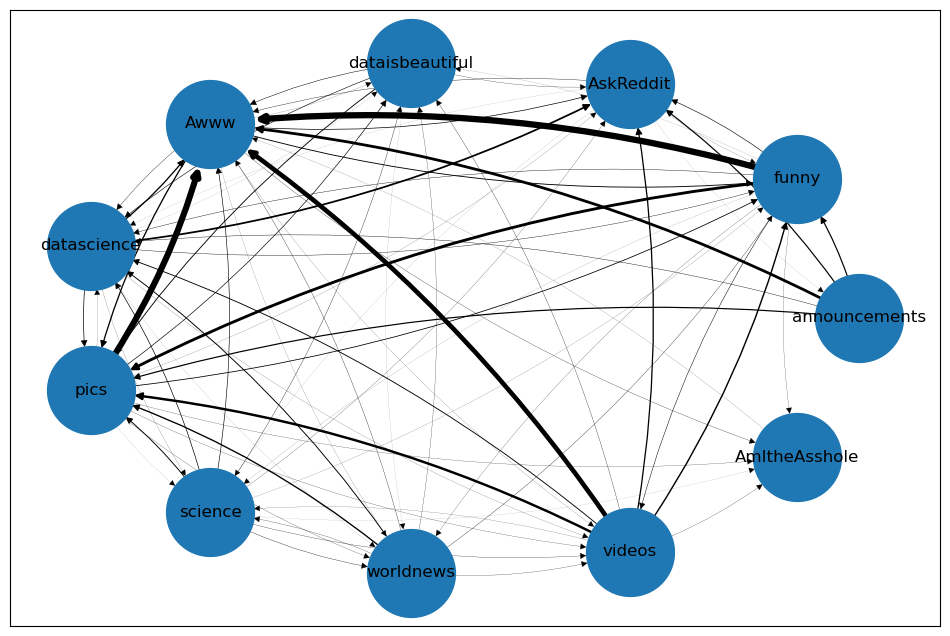

In [652]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

scale = 10

# Add the nodes to the graph
for sub in top_subreddits:
    G.add_node(sub)

# Add the edges to the graph, along with their weights
misguesses = {}
for source in top_subreddits:
    total = len(output[output['Actual'] == source])
    for target in top_subreddits:
        if source != target:
            misguessed = len(output[(output['Actual'] == source) & (output['Prediction'] == target)])
            misguesses[(source, target)] = misguessed / total
            if misguessed > .01:
                G.add_edge(source, target, weight=scale * misguessed / total)

# Draw the graph
pos = nx.circular_layout(G)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
# Create a figure that is 8 inches wide and 6 inches tall
plt.figure(figsize=(12, 8))

edge_width = [d['weight'] for (u, v, d) in G.edges(data=True)]
#nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='black', arrows=True, arrowsize=20)

nx.draw_networkx(G, pos, width=edge_width, connectionstyle="arc3,rad=0.1", node_size=4000)
#nx.draw(G, pos=pos)
plt.show()

# 5: Speculation on Model Improvements

The Naive Model preforms as expected on the easy to classify subreddits r/AmITheAsshole, r/AskReddit, and r/dataisbeautiful. But it completely falls apart on the subreddits r/funny and r/videos where the post titles provide very little information.

There are many immediately obvious things I can do to improve results:
- Include auxiliary information such as "title length" and "number of emojis" and "number of capital letters"
- Add a part_of_speach tokenizer
- More sophisticated embedding algorithms like Doc-2-Vec
- Compare other classification algorithms like XGBoost or Support Vector Machines
- Include more advanced information like "number of miss-spellings" and "sentiment"
- More Data

# 6: Create the New Models

While looking at new models we want to answer the following questions:
- What auxiliary information is important?
- Are different tokenizers better?
- How many words are needed in our Bag-of-Words?
- Do different classification algorithms (XGBoost, Support Vector Machine, Multinomial Logistic Regression, Random Forest)?
- Do more advanced embedding algorithms such as Averaged Word2Vec or Doc2Vec work better?

## Classes

In order to improve the results I need to test a lot of models. In a separate notebook I've created three classes to help with that. This will organize the information better.

In [124]:
%run Classes.ipynb

In [130]:
# Get the data again
data = [{'id': post.id, 'title': post.title, 'subreddit': post.subreddit.display_name} for post in posts]
df_raw = pd.DataFrame(data)

# Instantiate the Object
obj = Subreddit_Predictor()
obj.add_data(df_raw)
obj.ready_data()

In [660]:
obj.full_data

,title,subreddit,subreddit_num
id,,,
t93ec3,This subreddit is closed for new posts and com...,announcements,3
pg006s,COVID denialism and policy clarifications,announcements,3
pbmy5y,"Debate, dissent, and protest on Reddit",announcements,3
nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements,3
mi01fg,Second,announcements,3
...,...,...,...
10hudso,AITA for not wanting my sister to use my winte...,AmItheAsshole,0
10hu8h2,AITA for telling my recently adopted sister th...,AmItheAsshole,0
10hty0b,AITA for guy leaving our local gym and possibl...,AmItheAsshole,0


### Naive Model

The first thing we need to do is recreate our Naive Model. The embedding process uses Bag-of-Words. To make our lives easier in the future, we will create a generalized BoW embedding that can be easily modified.


*Cleaning* - Make everythign lower case and fix some common terms like "[oc]" to make it easier for the tokenizer
*Embedding* - "Training" a BoW model is really just creating a vacob list. We use NLTK's tokenizer
*Classifying* - As in our first approach we will use Random Forrest.

In [316]:
def clean_data(df):
    """
    :param df: Pandas DataFrame with a column 'title', or a Series
    :return: original df with the contents of the 'title' column altered. All lowercase. Replace "[oc]", "(oc)", and "[nsfw]" with "_oc_" and "_nsfw_" respectively.
    """

    if type(df) == pd.Series:
        df = pd.DataFrame(df)
        series = True
    else:
        series = False

    df['title'] = df['title'].apply(lambda s: s.lower())

    df['title'] = df['title'].apply(lambda s: s.replace("[oc]", "_oc_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(oc)", "_oc_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[nsfw]", "_nsfw_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(nsfw)", "_nsfw_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[wip]", "_wip_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(wip)", "_wip_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[serious]", "_serious_"))

    if series: df = df['title']

    return df

In [384]:
def get_vocab(corpus, tokenizer=nltk.word_tokenize, num_words=False, min_frequency=2):
    """
    :param corpus: a Pandas Series, or other iterable of cleaned text sentences.
    :param tokenizer: a function that takes in a sentence and outputs a list of tokens in that sentence.
    :param num_words: If an integer is given, then this is the max number of words in the vocab.
    :param min_frequency: If an integer is given, then this is the minimum number of times a word must appear in the corpus to be included in the vocab
    :return: A list of all of the tokens in our vocab.
    """
    tokenized_corpus = [tokenizer(sentence) for sentence in corpus]
    flat_list = [word for sublist in tokenized_corpus for word in sublist]
    freq_dist = FreqDist(flat_list)
    vocab = [word for word, freq in freq_dist.items() if freq >= min_frequency]
    if num_words:
        vocab = sorted(vocab, key=lambda x: freq_dist[x], reverse=True)
        vocab = vocab[:min(num_words, len(vocab))]
    vocab.sort()
    return vocab

In [318]:
from tqdm import tqdm
def _BoW_embed(titles, vocab, tokenizer=nltk.word_tokenize):
    """
    :param titles: A Pandas Series of titles to embed
    :param vocab: A List of all the words in the vocab
    :return:
    """
    df = pd.DataFrame(titles)
    df['title_tokens'] = df['title'].apply(tokenizer)
    new_cols = {'BoW: ' + word: df['title_tokens'].apply(lambda x: Counter(x)[word]) for word in tqdm(vocab)}
    #new_cols['Not in BoW'] = df['title_tokens'].apply(lambda lis: count_not_in_list2(lis, vocab))
    new_df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
    new_df = new_df.drop(columns=['title', 'title_tokens'])

    return new_df

In [385]:
Naive_BoW = Vectorizer('Naive BoW')
Naive_BoW._train = (lambda corpus: get_vocab(clean_data(corpus), num_words=False, min_frequency=2))
Naive_BoW._embed = (lambda titles, vocab : _BoW_embed(clean_data(titles), vocab))

In [386]:
temp_X_train = obj.X_train
Naive_BoW.train(temp_X_train)
Naive_BoW.embed(temp_X_train)

100%|██████████| 6423/6423 [01:39<00:00, 64.33it/s]


,BoW: !,BoW: #,BoW: $,BoW: %,BoW: &,BoW: ',BoW: '',BoW: 'd,BoW: 'data,BoW: 'disappointment,...,BoW: 🚀🌌,BoW: 🤍,BoW: 🤣,BoW: 🤯,BoW: 🥰,BoW: 🥶,BoW: 🥹,BoW: 🥺,BoW: 🦭,BoW: 🧡
id,,,,,,,,,,,,,,,,,,,,,
10jpzn7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103o877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10hc13d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101rmfl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10ijo3b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10i3iwn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10jhi1g,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10iwusm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [322]:
from sklearn.ensemble import RandomForestClassifier

def _RandomForest_train(X_train, Y_train):
    # Initialize the Random Forest model
    rf = RandomForestClassifier()
    # Train the model on the input data
    rf.fit(X_train, Y_train)
    # Output the trained model
    return rf


def _RandomForest_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)


In [324]:

RF = Classifier('RF')
RF._train = _RandomForest_train
RF._predict = _RandomForest_predict

obj.add_vectorizer(Naive_BoW)
obj.add_feature_vectors('Naive BoW')
obj.add_classifier(RF)
obj.train_model('Naive Model', 'Naive BoW', 'RF',
                description= "The Naive model using a full BoW vocab and RF with default parameters."
                )

100%|██████████| 6423/6423 [02:14<00:00, 47.66it/s]


In [327]:
obj.test_model('Naive Model')

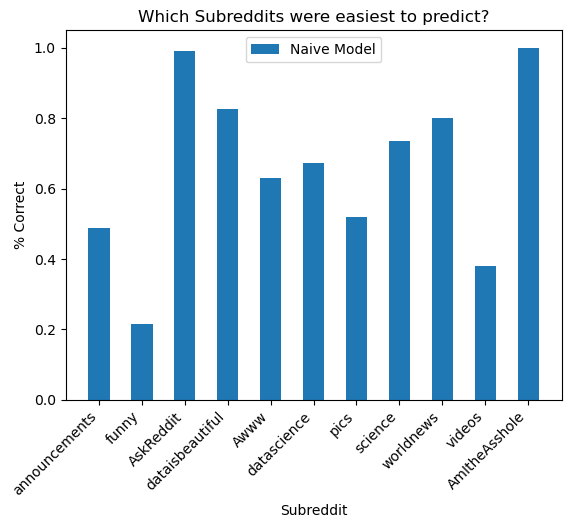

In [332]:
obj.compare(['Naive Model'])

### How many Words does our Bag-of-Words need?

To test this question we will train several models, identical except they use a different length vocabulary

100%|██████████| 5000/5000 [01:39<00:00, 50.29it/s]


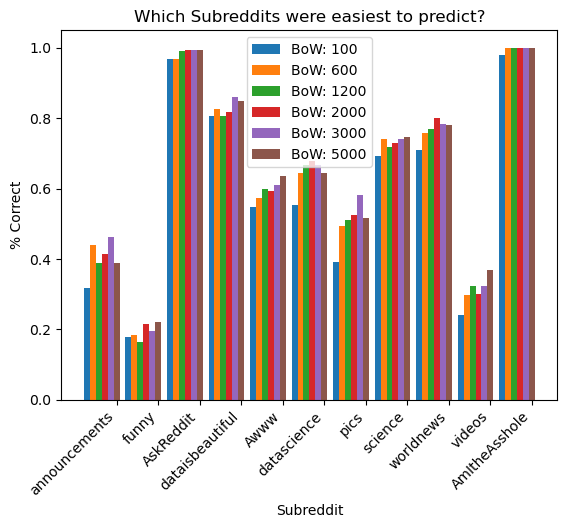

In [334]:
vocab_length = [100, 600, 1200, 2000, 3000, 5000]
models = []
for N in vocab_length:
    name = 'BoW: '+ str(N)
    vect = Vectorizer(name)
    vect._train = (lambda corpus: get_vocab(clean_data(corpus), num_words=N, min_frequency=2))
    vect._embed = (lambda titles, vocab : _BoW_embed(clean_data(titles), vocab))
    obj.add_vectorizer(vect)
    obj.add_feature_vectors(name)
    obj.train_model(name, name, 'RF', description='Naive BoW RF model with ' + str(N) + ' words.')
    obj.test_model(name)
    models.append(name)

obj.compare(models)


In [335]:

name = 'BoW: 6500'
vect = Vectorizer(name)
vect._train = (lambda corpus: get_vocab(clean_data(corpus), num_words=False, min_frequency=2))
vect._embed = (lambda titles, vocab : _BoW_embed(clean_data(titles), vocab))
obj.add_vectorizer(vect)
obj.add_feature_vectors(name)
obj.train_model(name, name, 'RF', description='Naive BoW RF model with ' + str(6500) + ' words.')
obj.test_model(name)
models.append(name)

100%|██████████| 6423/6423 [02:15<00:00, 47.46it/s]


In [336]:

name = 'BoW: 9000'
vect = Vectorizer(name)
vect._train = (lambda corpus: get_vocab(clean_data(corpus), num_words=9000, min_frequency=1))
vect._embed = (lambda titles, vocab : _BoW_embed(clean_data(titles), vocab))
obj.add_vectorizer(vect)
obj.add_feature_vectors(name)
obj.train_model(name, name, 'RF', description='Naive BoW RF model with ' + str(9000) + ' words.')
obj.test_model(name)
models.append(name)

100%|██████████| 9000/9000 [03:02<00:00, 49.36it/s]


In [337]:

name = 'BoW: 14000'
vect = Vectorizer(name)
vect._train = (lambda corpus: get_vocab(clean_data(corpus), num_words=14000, min_frequency=1))
vect._embed = (lambda titles, vocab : _BoW_embed(clean_data(titles), vocab))
obj.add_vectorizer(vect)
obj.add_feature_vectors(name)
obj.train_model(name, name, 'RF', description='Naive BoW RF model with ' + str(14000) + ' words.')
obj.test_model(name)
models.append(name)


100%|██████████| 14000/14000 [04:44<00:00, 49.23it/s]


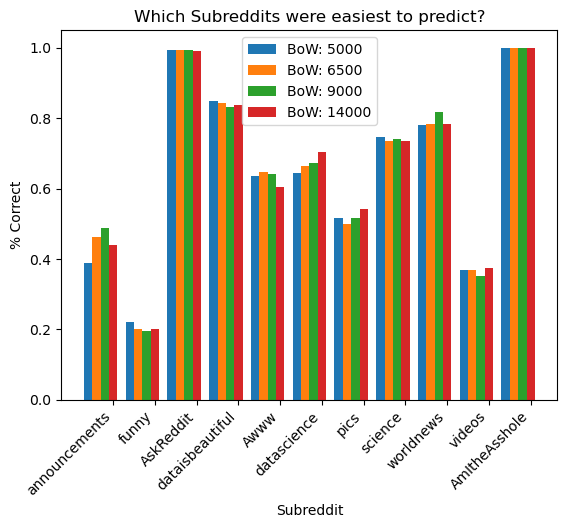

In [338]:
obj.compare(['BoW: 5000', 'BoW: 6500', 'BoW: 9000', 'BoW: 14000'])

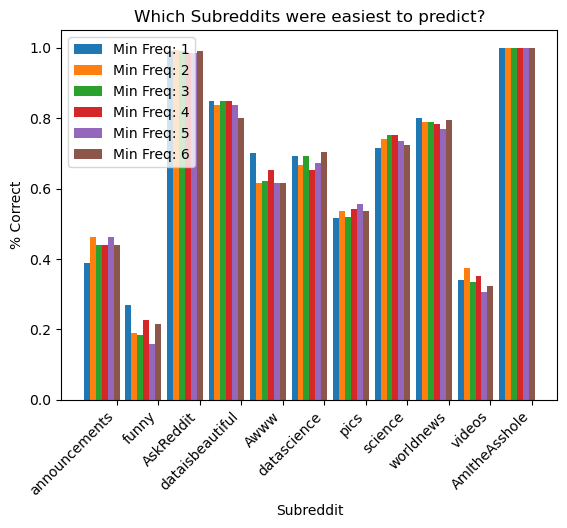

In [341]:
obj.compare(['Min Freq: 1', 'Min Freq: 2', 'Min Freq: 3', 'Min Freq: 4', 'Min Freq: 5', 'Min Freq: 6' ])

100%|██████████| 1135/1135 [00:23<00:00, 47.75it/s]


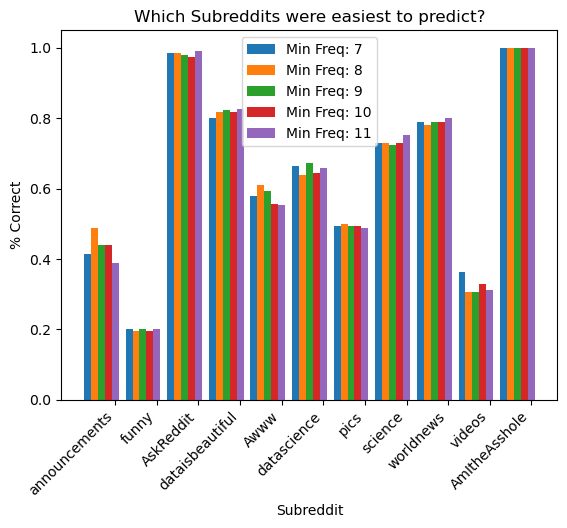

In [340]:
min_freq = range(7, 12)
models = []
for m in min_freq:
    name = 'Min Freq: '+ str(m)
    vect = Vectorizer(name)
    vect._train = (lambda corpus: get_vocab(clean_data(corpus), num_words=False, min_frequency=m))
    vect._embed = (lambda titles, vocab : _BoW_embed(clean_data(titles), vocab))
    obj.add_vectorizer(vect)
    obj.add_feature_vectors(name)
    obj.train_model(name, name, 'RF', description='Naive BoW RF model with only words that appear at least ' + str(m) + ' times.')
    obj.test_model(name)
    models.append(name)

obj.compare(models)

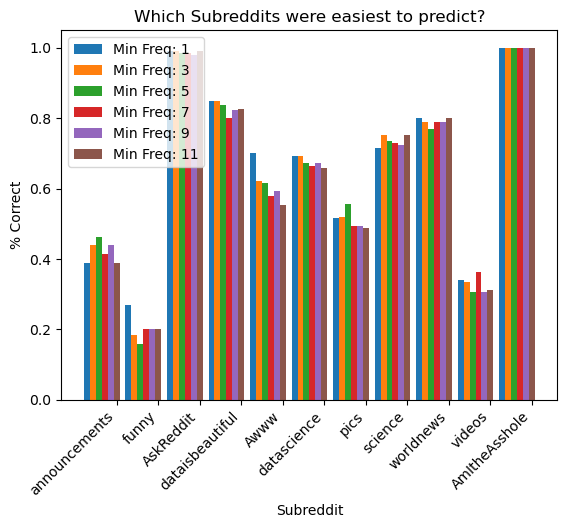

In [342]:
obj.compare(['Min Freq: 1', 'Min Freq: 3', 'Min Freq: 5', 'Min Freq: 7', 'Min Freq: 9', 'Min Freq: 11' ])

It seems that the results are all very similar. As long as there a roughly 3000 words I feel that the model preforms adequetly.

## What Auxiliary Data can Improve the Model?

Create several new models with the following additional information:
- Title Length
- Number of Emojis
- Number of Capital Letters

In [390]:
def get_BoW_embedder(tokenizer = nltk.word_tokenize, cleaner = clean_data, num_chars = False, num_tokens = False, num_emojis = False, num_caps = False, num_lower = False, testing = False):
    """
    Returns the embedding function with the desired properties
    :param tokenizer:
    :param cleaner:
    :param num_char:
    :param num_tokens:
    :param num_emojis:
    :param num_caps:
    :param num_lower:
    :return:
    """

    def embedder(titles, vocab):
        """
        :param titles: An uncleaned Pandas Series of titles
        :param vocab: A list of words to put in the BoW
        :return: A Pandas DataFrame of the embedded titles.
        """
        df = pd.DataFrame(titles)

        #First Pass Features

        if num_chars:
            df['Num: Chars'] = df['title'].apply(len)
        if num_caps:
            df['Num: Caps'] = df['title'].apply(lambda s: len(re.findall(r'[A-Z]', s)))
        if num_lower:
            df['Num: Lower'] = df['title'].apply(lambda s: len(re.findall(r'[a-z]', s)))
        if num_emojis:
            df['Num: Emoji'] = df['title'].apply(lambda s: len(re.findall(
                r'[\u2600-\u27bf]' # Miscellaneous Symbols and Pictographs (☀️, 🌁, 🌊)
                r'|[\U0001f300-\U0001f5ff]' # Emoticons (🌞, 🌝, 🌚)
                r'|[\U0001f600-\U0001f64f]' # Transport and Map Symbols (🚗, 🚕, 🚆)
                r'|[\U0001f680-\U0001f6ff]' # Transport and Map Symbols (🚁, 🚲, 🛴)
                r'|[\u2b00-\u2bff]' # Additional emoticons (⬛, ❤️, 🔥)
                , s)))

        #Cleaning & Tokenization

        df['title'] = cleaner(df['title'])
        df['title_tokens'] = df['title'].apply(tokenizer)

        #Second Pass Features

        if num_tokens:
            df['Num: Tokens'] = df['title_tokens'].apply(len)

        new_cols = {'BoW: ' + word: df['title_tokens'].apply(lambda x: Counter(x)[word]) for word in tqdm(vocab)}
        #new_cols['Not in BoW'] = df['title_tokens'].apply(lambda lis: count_not_in_list2(lis, vocab))
        new_df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)

        if (not testing):
            new_df = new_df.drop(columns=['title', 'title_tokens'])

        return new_df

    return embedder

In [399]:
temp_titles = obj.X_train
temp_vocab = get_vocab(clean_data(temp_titles), num_words = 300)
temp_embedder = get_BoW_embedder(num_chars=True, num_lower=True, num_emojis=True, num_tokens=True, num_caps=True, testing = True)



In [400]:
temp_embedder(temp_titles, temp_vocab)

100%|██████████| 3000/3000 [00:42<00:00, 70.17it/s]


,title,Num: Chars,Num: Caps,Num: Lower,Num: Emoji,title_tokens,Num: Tokens,BoW: !,BoW: #,BoW: $,...,BoW: ’,BoW: “,BoW: ”,BoW: ♥,BoW: ❤️,BoW: 🐾,BoW: 😂,BoW: 😅,BoW: 😍,BoW: 🥰
id,,,,,,,,,,,,,,,,,,,,,
10jpzn7,friends from parallel universe,30,0,27,0,"[friends, from, parallel, universe]",4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103o877,the emoji use in apology messages influences c...,94,1,80,0,"[the, emoji, use, in, apology, messages, influ...",14,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10hc13d,who lakes a baby cockapoo??,27,1,20,0,"[who, lakes, a, baby, cockapoo, ?, ?]",7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101rmfl,_oc_ tracking the fuel mileage in one of my ve...,92,3,66,0,"[_oc_, tracking, the, fuel, mileage, in, one, ...",18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10ijo3b,aita for not paying rent?,25,4,16,0,"[aita, for, not, paying, rent, ?]",6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10i3iwn,the menu at my local cheese shop,32,1,25,0,"[the, menu, at, my, local, cheese, shop]",7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10jhi1g,"random surfer in palos verdes, california",41,4,31,0,"[random, surfer, in, palos, verdes, ,, califor...",7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10iwusm,found a 6 leaf clover,21,1,15,0,"[found, a, 6, leaf, clover]",5,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [402]:
models = []

name = 'BoW'
BoW = Vectorizer(name)
BoW._train= (lambda corpus: get_vocab(clean_data(corpus), num_words=3000))
BoW._embed = get_BoW_embedder()
obj.add_vectorizer(BoW)
obj.add_feature_vectors(name)
obj.train_model(name, name, 'RF',
                description= "Naive BoW RF model with no additional information"
                )
obj.test_model(name)
models.append(name)

100%|██████████| 3000/3000 [00:55<00:00, 53.68it/s]


In [403]:
name = 'BoW + num_chars'
BoW = Vectorizer(name)
BoW._train= (lambda corpus: get_vocab(clean_data(corpus), num_words=3000))
BoW._embed = get_BoW_embedder(num_chars=True)
obj.add_vectorizer(BoW)
obj.add_feature_vectors(name)
obj.train_model(name, name, 'RF',
                description= "BoW RF model with additional information of total character length"
                )
obj.test_model(name)
models.append(name)

100%|██████████| 3000/3000 [00:58<00:00, 50.97it/s]


In [404]:
name = 'BoW + num_tokens'
BoW = Vectorizer(name)
BoW._train= (lambda corpus: get_vocab(clean_data(corpus), num_words=3000))
BoW._embed = get_BoW_embedder(num_tokens=True)
obj.add_vectorizer(BoW)
obj.add_feature_vectors(name)
obj.train_model(name, name, 'RF',
                description= "BoW RF model with additional information of total number of tokens"
                )
obj.test_model(name)
models.append(name)

100%|██████████| 3000/3000 [01:00<00:00, 49.85it/s]


In [405]:
name = 'BoW + num_caps'
BoW = Vectorizer(name)
BoW._train= (lambda corpus: get_vocab(clean_data(corpus), num_words=3000))
BoW._embed = get_BoW_embedder(num_caps=True)
obj.add_vectorizer(BoW)
obj.add_feature_vectors(name)
obj.train_model(name, name, 'RF',
                description= "BoW RF model with additional information of total number of caps"
                )
obj.test_model(name)
models.append(name)

100%|██████████| 3000/3000 [01:03<00:00, 47.51it/s]


In [406]:
name = 'BoW + num_emojis'
BoW = Vectorizer(name)
BoW._train= (lambda corpus: get_vocab(clean_data(corpus), num_words=3000))
BoW._embed = get_BoW_embedder(num_emojis=True)
obj.add_vectorizer(BoW)
obj.add_feature_vectors(name)
obj.train_model(name, name, 'RF',
                description= "BoW RF model with additional information of number of emojis"
                )
obj.test_model(name)
models.append(name)

100%|██████████| 3000/3000 [01:01<00:00, 48.61it/s]


In [407]:
name = 'BoW + num_lower'
BoW = Vectorizer(name)
BoW._train= (lambda corpus: get_vocab(clean_data(corpus), num_words=3000))
BoW._embed = get_BoW_embedder(num_lower=True)
obj.add_vectorizer(BoW)
obj.add_feature_vectors(name)
obj.train_model(name, name, 'RF',
                description= "BoW RF model with additional information of total lower case charactersh"
                )
obj.test_model(name)
models.append(name)

100%|██████████| 3000/3000 [00:59<00:00, 50.32it/s]


In [408]:
name = 'BoW + All'
BoW = Vectorizer(name)
BoW._train= (lambda corpus: get_vocab(clean_data(corpus), num_words=3000))
BoW._embed = get_BoW_embedder(num_chars=True, num_tokens=True, num_caps=True, num_lower=True, num_emojis=True)
obj.add_vectorizer(BoW)
obj.add_feature_vectors(name)
obj.train_model(name, name, 'RF',
                description= "BoW RF model with all additional information"
                )
obj.test_model(name)
models.append(name)

100%|██████████| 3000/3000 [00:59<00:00, 50.51it/s]


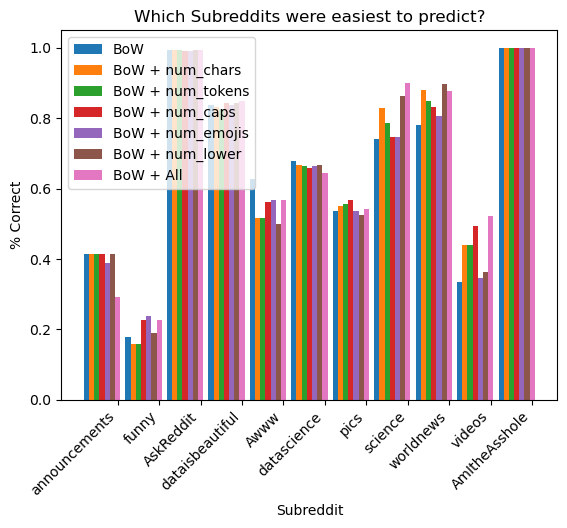

In [409]:
obj.compare(models)

In [410]:
name = 'BoW + Caps + Tokens'
BoW = Vectorizer(name)
BoW._train= (lambda corpus: get_vocab(clean_data(corpus), num_words=3000))
BoW._embed = get_BoW_embedder(num_tokens=True, num_caps=True)
obj.add_vectorizer(BoW)
obj.add_feature_vectors(name)
obj.train_model(name, name, 'RF',
                description= "BoW RF model with caps and token information"
                )
obj.test_model(name)


100%|██████████| 3000/3000 [01:00<00:00, 49.66it/s]


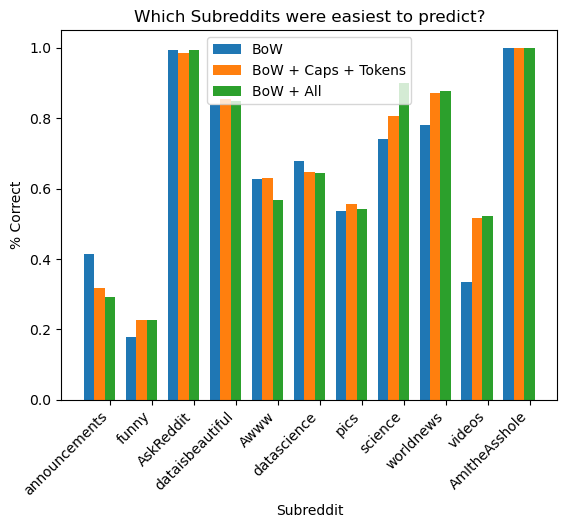

In [411]:
obj.compare(['BoW', 'BoW + Caps + Tokens', 'BoW + All'])

In [ ]:

obj.add_vectorizer(vect)
obj.add_feature_vectors(name)
obj.train_model(name, name, 'RF', description='Naive BoW RF model with only words that appear at least ' + str(m) + ' times.')
obj.test_model(name)
models.append(name)

In [401]:


def emoji_tokenize(text):
    # Regular expression to match emojis
    emoji_pattern = re.compile("["
                               u"\U0001f600-\U0001f64f"  # emoticons
                               u"\U0001f300-\U0001f5ff"  # symbols & pictographs
                               u"\U0001f680-\U0001f6ff"  # transport & map symbols
                               u"\U0001f1e0-\U0001f1ff"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    # Finding all emojis in the text
    emojis = emoji_pattern.findall(text)
    # Replacing emojis with spaces and tokenizing the text
    text = emoji_pattern.sub(" ", text)
    tokens = nltk.word_tokenize(text)
    # Adding emojis as separate tokens
    tokens.extend(emojis)
    return tokens

temp_titles = obj.X_train
temp_vocab = get_vocab(clean_data(temp_titles), num_words = 3000, tokenizer=emoji_tokenize)
temp_embedder = get_BoW_embedder(num_chars=True, num_lower=True, num_emojis=True, num_tokens=True, num_caps=True, testing = True, tokenizer=emoji_tokenize)

temp_embedder(temp_titles, temp_vocab)


100%|██████████| 3000/3000 [00:44<00:00, 67.79it/s]


,title,Num: Chars,Num: Caps,Num: Lower,Num: Emoji,title_tokens,Num: Tokens,BoW: !,BoW: #,BoW: $,...,BoW: 🐕,BoW: 🐾,BoW: 😂,BoW: 😅,BoW: 😍,BoW: 😍😍,BoW: 😍😍😍,BoW: 🤣,BoW: 🥰,BoW: 🥹
id,,,,,,,,,,,,,,,,,,,,,
10jpzn7,friends from parallel universe,30,0,27,0,"[friends, from, parallel, universe]",4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103o877,the emoji use in apology messages influences c...,94,1,80,0,"[the, emoji, use, in, apology, messages, influ...",14,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10hc13d,who lakes a baby cockapoo??,27,1,20,0,"[who, lakes, a, baby, cockapoo, ?, ?]",7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101rmfl,_oc_ tracking the fuel mileage in one of my ve...,92,3,66,0,"[_oc_, tracking, the, fuel, mileage, in, one, ...",18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10ijo3b,aita for not paying rent?,25,4,16,0,"[aita, for, not, paying, rent, ?]",6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10i3iwn,the menu at my local cheese shop,32,1,25,0,"[the, menu, at, my, local, cheese, shop]",7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10jhi1g,"random surfer in palos verdes, california",41,4,31,0,"[random, surfer, in, palos, verdes, ,, califor...",7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10iwusm,found a 6 leaf clover,21,1,15,0,"[found, a, 6, leaf, clover]",5,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [366]:
sentences = [
    "I love 🍕 pizza! 🍕",  # False
    "I love pizza! 🍕", # False
    "I love pizza! 🍕🍕🍕", # False
    "I love 🍕 pizza! 🍕🍕🍕", # False
    "I løve אַַ pizza! 🍕", # True
    "I løve אַַ🍕 pizza! 🍕🍕🍕", # True
    "I løve 🍕 pi🍕za! אַַ🍕🍕🍕", # True
    "I løve 🍕 pi🍕za! אַַ🍕🍕🍕🍕", # True
    "I løve 🍕 pi🍕za! אַַ🍕🍕🍕🍕🍕", # True
    "I løve 🍕 pi🍕za! אַַ🍕🍕🍕🍕🍕🍕", #True
]
sentences =  pd.DataFrame({'title' : sentences})

_BoW_embed(clean_data(sentences), get_vocab(clean_data(sentences['title']), min_frequency=2))

100%|██████████| 8/8 [00:00<00:00, 8025.46it/s]


,BoW: i,BoW: love,BoW: 🍕,BoW: pizza,BoW: !,BoW: 🍕🍕🍕,BoW: løve,BoW: pi🍕za
0,1,1,2,1,1,0,0,0
1,1,1,1,1,1,0,0,0
2,1,1,0,1,1,1,0,0
3,1,1,1,1,1,1,0,0
4,1,0,1,1,1,0,1,0
5,1,0,0,1,1,1,1,0
6,1,0,1,0,1,0,1,1
7,1,0,1,0,1,0,1,1
8,1,0,1,0,1,0,1,1
9,1,0,1,0,1,0,1,1


In [ ]:

def _BoW_train(X_train):
    """
    This is really just creating the dictionary
    """
    model = CountVectorizer(word_tokenize)
    X_train = clean_data(X_train)
    model.fit_transform(X_train)
    return model



In [215]:

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')





def add_indicative_words(df, num_words):
    df['title_tokens'] = df['title'].apply(nltk.word_tokenize)
    all_words = [word for tokens in df['title_tokens'] for word in tokens]
    freq_dist = nltk.FreqDist(all_words)
    indicative_words = [word for word, count in freq_dist.most_common(num_words)]
    #new_cols = {word: df['title_tokens'].apply(lambda x: int(word in x)) for word in indicative_words}
    new_cols = {'BoW: '+ word: df['title_tokens'].apply(lambda x: Counter(x)[word]) for word in indicative_words}
    new_df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
    return new_df

def _BoW_embed(titles, model):
    """
    :param titles: Pandas Series of sentences
    :param model: A trained CountVectorizer model
    :return: A Pandas DataFrame of the embedded sentences. The index of the df should be the same index as titles. Each new column in the df should be called "BoW: word" where word is the word in the Bag-of-Words embedding
    """
    titles = clean_data(titles)
    embedding = model.transform(titles).toarray()

    dic = {}
    for word, idx in model.vocabulary_.items():
        dic["BoW: " + word] = embedding[:, idx]
    df = pd.DataFrame(dic)
    df['id']=titles.index
    df = df.set_index('id')
    df['title']=titles
    return df


In [ ]:
import nltk
from nltk.probability import FreqDist




def count_not_in_list2(list1, list2):
    count = 0
    for item in list1:
        if item not in list2:
            count += 1
    return count




#temp_vocab = get_vocab(obj.X_train)
#_BoW_embed(obj.X_train, temp_vocab)

In [ ]:
def get_vocab(corpus, tokenizer = nltk.word_tokenize, num_words = False, min_frequency = 2):
    """
    :param corpus: a Pandas Series, or other iterable of cleaned text sentences.
    :param tokenizer: a function that takes in a sentence and outputs a list of tokens in that sentence.
    :param num_words: If an integer is given, then this is the max number of words in the vocab.
    :param min_frequency: If an integer is given, then this is the minimum number of times a word must appear in the corpus to be included in the vocab
    :return: A list of all of the tokens in our vocab.
    """

    df = pd.DataFrame(corpus)
    df['title_tokens'] = df['title'].apply(tokenizer)
    all_words = [word for token in ]

In [278]:
import nltk
from nltk.probability import FreqDist

def get_vocab(corpus, tokenizer=nltk.word_tokenize, num_words=False, min_frequency=2):
    """
    :param corpus: a Pandas Series, or other iterable of cleaned text sentences.
    :param tokenizer: a function that takes in a sentence and outputs a list of tokens in that sentence.
    :param num_words: If an integer is given, then this is the max number of words in the vocab.
    :param min_frequency: If an integer is given, then this is the minimum number of times a word must appear in the corpus to be included in the vocab
    :return: A list of all of the tokens in our vocab.
    """
    tokenized_corpus = [tokenizer(sentence) for sentence in corpus]
    flat_list = [word for sublist in tokenized_corpus for word in sublist]
    freq_dist = FreqDist(flat_list)
    vocab = [word for word, freq in freq_dist.items() if freq >= min_frequency]
    if num_words:
        vocab = sorted(vocab, key=lambda x: freq_dist[x], reverse=True)
        vocab = vocab[:min(num_words,len(vocab))]
    return vocab

def count_not_in_list2(list1, list2):
    count = 0
    for item in list1:
        if item not in list2:
            count +=1
    return count

def _BoW_embed(titles, vocab, tokenizer=nltk.word_tokenize):
    """
    :param titles: A Pandas Series of titles to embed
    :param vocab: A List of all the words in the vocab
    :return:
    """
    df = pd.DataFrame(titles)
    df['title_tokens'] = df['title'].apply(tokenizer)
    new_cols = {'BoW: '+ word: df['title_tokens'].apply(lambda x: Counter(x)[word]) for word in vocab}
    new_cols['Not in BoW'] =  df['title_tokens'].apply(lambda lis: count_not_in_list2(lis, vocab))
    new_df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)

    return new_df


#temp_vocab = get_vocab(obj.X_train)
#_BoW_embed(obj.X_train, temp_vocab)

In [279]:
temp_titles = clean_data(obj.X_train)
temp_vocab = get_vocab(temp_titles, num_words=1000)

In [280]:
temp_embedding = _BoW_embed(temp_titles, temp_vocab)
temp_embedding

,title,title_tokens,BoW: the,BoW: to,BoW: ?,"BoW: ,",BoW: of,BoW: a,BoW: in,BoW: for,...,BoW: modi,BoW: results,BoW: adding,BoW: 200,BoW: diabetes,BoW: weapons,BoW: longer,BoW: travel,BoW: protein,Not in BoW
id,,,,,,,,,,,,,,,,,,,,,
10jpzn7,friends from parallel universe,"[friends, from, parallel, universe]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
103o877,the emoji use in apology messages influences c...,"[the, emoji, use, in, apology, messages, influ...",1,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,8
10hc13d,who lakes a baby cockapoo??,"[who, lakes, a, baby, cockapoo, ?, ?]",0,0,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
101rmfl,_oc_ tracking the fuel mileage in one of my ve...,"[_oc_, tracking, the, fuel, mileage, in, one, ...",1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,6
10ijo3b,aita for not paying rent?,"[aita, for, not, paying, rent, ?]",0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10i3iwn,the menu at my local cheese shop,"[the, menu, at, my, local, cheese, shop]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
10jhi1g,"random surfer in palos verdes, california","[random, surfer, in, palos, verdes, ,, califor...",0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4
10iwusm,found a 6 leaf clover,"[found, a, 6, leaf, clover]",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3


In [ ]:
type

In [285]:
temp_embedding['Not in BoW'].sort_values(ascending=False)

id
106vdh1    27
zzuewu     27
zx914f     26
10a9fk6    26
10gexnf    25
           ..
10k7y2y     0
10jd28b     0
100w2ap     0
10kff3q     0
zzle3n      0
Name: Not in BoW, Length: 7619, dtype: int64

In [ ]:
def _scratch_train(X_train):
    df = pd.DataFrame(X_train)
    df['title_tokens'] = df['title'].apply(nltk.word_tokenize)
    all_words = [word for tokens in df['title_tokens'] for word in tokens]
    freq_dist = nltk.FreqDist(all_words)
    indicative_words = [word for word, count in freq_dist.most_common(num_words)]

In [225]:
temp_data = obj.X_train
temp_model = _BoW_train(temp_data)
temp_df = _BoW_embed(obj.X_train, temp_model)
temp_df

,BoW: friends,BoW: from,BoW: parallel,BoW: universe,BoW: the,BoW: emoji,BoW: use,BoW: in,BoW: apology,BoW: messages,...,BoW: balanced,BoW: malaria,BoW: surfer,BoW: palos,BoW: verdes,BoW: tortilla,BoW: quesadilla,BoW: loyalist,BoW: dials,title
id,,,,,,,,,,,,,,,,,,,,,
10jpzn7,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,friends from parallel universe
103o877,0,0,0,0,1,1,1,2,1,1,...,0,0,0,0,0,0,0,0,0,the emoji use in apology messages influences c...
10hc13d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,who lakes a baby cockapoo??
101rmfl,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,_oc_ tracking the fuel mileage in one of my ve...
10ijo3b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,aita for not paying rent?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10i3iwn,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,the menu at my local cheese shop
10jhi1g,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,1,0,0,0,0,"random surfer in palos verdes, california"
10iwusm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,found a 6 leaf clover


In [228]:
temp_data

id
10jpzn7                       friends from parallel universe
103o877    The emoji use in apology messages influences c...
10hc13d                          Who lakes a baby cockapoo??
101rmfl    [OC] Tracking the fuel mileage in one of my ve...
10ijo3b                            AITA for not paying rent?
                                 ...                        
10i3iwn                     The menu at my local cheese shop
10jhi1g            Random surfer in Palos Verdes, California
10iwusm                                Found a 6 leaf clover
10g5xxj    My wife had a tortilla blanket, so I got a che...
10gs02p    Putin loyalist dials up nuclear rhetoric as NA...
Name: title, Length: 7619, dtype: object

In [233]:
for word, count in list(temp_df.loc['109zxvt'].items()):
    if count>0:
        print(word, count)


BoW: cat 1
BoW: sleeping 1


TypeError: '>' not supported between instances of 'str' and 'int'

In [218]:
obj.X_train.loc['10hii5k']

"🧩 [WIP] drag'n drop interactive dashboard editor"

In [181]:
dic = {val:key for (key,val) in temp_model.vocabulary_.items()}
lis = list(dic.keys())
lis.sort()
lis

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


,BoW: friends,BoW: from,BoW: parallel,BoW: universe,BoW: the,BoW: emoji,BoW: use,BoW: in,BoW: apology,BoW: messages,...,BoW: pfaueninsel,BoW: balanced,BoW: malaria,BoW: surfer,BoW: palos,BoW: verdes,BoW: tortilla,BoW: quesadilla,BoW: loyalist,BoW: dials
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7614,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7615,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,1,1,0,0,0,0
7616,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7617,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [196]:
def _BoW_embed(titles, model):
    """
    :param titles: Pandas Series of sentences
    :param model: A trained CountVectorizer model
    :return: A Pandas DataFrame of the embedded sentences. The index of the df should be the same index as titles. Each new column in the df should be called "BoW: word" where word is the word in the Bag-of-Words embedding
    """
    titles = clean_data(titles)
    embedding = model.transform(titles)
    df = pd.DataFrame(embedding.toarray(), index=titles.index)
    df.columns = ["BoW: " + word for word, index in model.vocabulary_.items()]
    for i, row in df.iterrows():
        pos_cols = row[row > 0].to_dict()
        print("For row ",i,":", pos_cols)
    return df

_BoW_embed(temp_data[:3], temp_model)

For row  10jpzn7 : {'BoW: bank': 1, 'BoW: aerobic': 1, 'BoW: exploring': 1, 'BoW: cheats': 1}
For row  103o877 : {'BoW: traducir': 1, 'BoW: robustly': 1, 'BoW: ratties': 1, 'BoW: hkd': 2, 'BoW: welcomes': 1, 'BoW: endotracheal': 1, 'BoW: 308': 1, 'BoW: loses': 1, 'BoW: unattractive': 1, 'BoW: extracts': 1, 'BoW: communicating': 1, 'BoW: olé': 1}
For row  10hc13d : {'BoW: argument': 1, 'BoW: boop': 1, 'BoW: bureau': 1, 'BoW: screw': 1}


,BoW: friends,BoW: from,BoW: parallel,BoW: universe,BoW: the,BoW: emoji,BoW: use,BoW: in,BoW: apology,BoW: messages,...,BoW: pfaueninsel,BoW: balanced,BoW: malaria,BoW: surfer,BoW: palos,BoW: verdes,BoW: tortilla,BoW: quesadilla,BoW: loyalist,BoW: dials
id,,,,,,,,,,,,,,,,,,,,,
10jpzn7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103o877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10hc13d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [195]:
temp_data[:3]

id
10jpzn7                       friends from parallel universe
103o877    The emoji use in apology messages influences c...
10hc13d                          Who lakes a baby cockapoo??
Name: title, dtype: object

In [201]:
def _BoW_embed(titles, model):
    """
    :param titles: Pandas Series of sentences
    :param model: A trained CountVectorizer model
    :return: A Pandas DataFrame of the embedded sentences. The index of the df should be the same index as titles. Each new column in the df should be called "BoW: word" where word is the word in the Bag-of-Words embedding
    """
    titles = clean_data(titles)
    embedding = model.transform(titles).toarray()
    col_names = ["BoW: " + word for word, index in model.vocabulary_.items()]
    df = pd.DataFrame(embedding, columns=col_names, index=titles.index)

    #printing the dictionary of all the columns that have positive values
    for i in range(len(df)):
        positive_cols = {}
        for col in df.columns:
            if df.loc[i,col] > 0:
                positive_cols[col] = df.loc[i,col]
        print(positive_cols)
    return df

_BoW_embed(temp_data[:3], temp_model)


KeyError: 0

In [205]:
temp_titles = clean_data(obj.X_train)
temp_embedding = temp_model.transform(temp_titles).toarray()
col_names = ["BoW: " + word for word, index in temp_model.vocabulary_.items()]
temp_df = pd.DataFrame(temp_embedding, columns=col_names, index=temp_titles.index)
temp_df['title'] = temp_titles
temp_df

,BoW: friends,BoW: from,BoW: parallel,BoW: universe,BoW: the,BoW: emoji,BoW: use,BoW: in,BoW: apology,BoW: messages,...,BoW: balanced,BoW: malaria,BoW: surfer,BoW: palos,BoW: verdes,BoW: tortilla,BoW: quesadilla,BoW: loyalist,BoW: dials,title
id,,,,,,,,,,,,,,,,,,,,,
10jpzn7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,friends from parallel universe
103o877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,the emoji use in apology messages influences c...
10hc13d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,who lakes a baby cockapoo??
101rmfl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,_oc_ tracking the fuel mileage in one of my ve...
10ijo3b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,aita for not paying rent?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10i3iwn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,the menu at my local cheese shop
10jhi1g,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"random surfer in palos verdes, california"
10iwusm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,found a 6 leaf clover


In [200]:
def _BoW_embed(titles, model):
    """
    :param titles: Pandas Series of sentences
    :param model: A trained CountVectorizer model
    :return: A Pandas DataFrame of the embedded sentences. The index of the df should be the same index as titles. Each new column in the df should be called "BoW: word" where word is the word in the Bag-of-Words embedding
    """
    titles = clean_data(titles)
    embedding = model.transform(titles).toarray()
    df = pd.DataFrame(embedding, index=titles.index)

    # Create the column names
    feature_names = [f"BoW: {word}" for word, idx in model.vocabulary_.items()]

    # Concatenate the columns
    df = pd.concat([df], axis=1, keys=feature_names)
    df.columns = df.columns.get_level_values(1)

    for idx, row in df.iterrows():
        cols_with_positive_values = {col:value for col, value in row.items() if value>0}
        print(cols_with_positive_values)

    return df
_BoW_embed(temp_data[:3], temp_model)


{5009: 1, 5016: 1, 8723: 1, 12740: 1}
{973: 1, 3193: 1, 4143: 1, 6100: 2, 6206: 1, 7564: 1, 8468: 1, 9938: 1, 10221: 1, 10852: 1, 12134: 1, 12834: 1}
{1300: 1, 2566: 1, 6807: 1, 13276: 1}


,0,1,2,3,4,5,6,7,8,9,...,13565,13566,13567,13568,13569,13570,13571,13572,13573,13574
id,,,,,,,,,,,,,,,,,,,,,
10jpzn7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103o877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10hc13d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
type(list(dict(pd.DataFrame(temp_model.transform(["hello world"]).toarray())).values())[2])

pandas.core.series.Series

In [ ]:

BoW = Vectorizer('BoW')
BoW.description = "Naive Bag-of-Words embedding"

BoW._train = _BoW_train
BoW._embed = _BoW_embed

obj.add_vectorizer(BoW)
obj.add_feature_vectors('BoW')

obj.Feature_Vectors['BoW']

In [138]:
clean_data(obj.X_train)

id
10jpzn7                       friends from parallel universe
103o877    the emoji use in apology messages influences c...
10hc13d                          who lakes a baby cockapoo??
101rmfl    _oc_ tracking the fuel mileage in one of my ve...
10ijo3b                            aita for not paying rent?
                                 ...                        
10i3iwn                     the menu at my local cheese shop
10jhi1g            random surfer in palos verdes, california
10iwusm                                found a 6 leaf clover
10g5xxj    my wife had a tortilla blanket, so i got a che...
10gs02p    putin loyalist dials up nuclear rhetoric as na...
Name: title, Length: 7619, dtype: object

## Vectorizers

Here we will create a few different vectorizers

### Order of Operations

Each Vectorizer will need some additional information

auxiliary_features -> clean_data -> tokenizer

In [106]:
# Global auxiliary Features

import re

def auxiliary_features(titles):
    """
    :param titles: Pandas Series of original post titles.
    :return: Pandas DataFrame, indexed by 'id', with auxiliary information in it.
        Auxiliary Features:
            length - number of characters in title
            num_caps - number of capital letters in title
            num_emoji - number of emojis in title
            ? num_pos_[] - number of each part of speach
    """

    df = pd.DataFrame(titles)
    df['num_chars'] = df['title'].apply(len)
    df['num_caps'] = df['title'].apply(lambda s: len(re.findall(r'[A-Z]', s)))
    df['num_lower'] = df['title'].apply(lambda s: len(re.findall(r'[a-z]', s)))
    df['num_emojis'] = df['title'].apply(lambda s: len(re.findall(
        r'[\u2600-\u27bf]' # Miscellaneous Symbols and Pictographs (☀️, 🌁, 🌊)
        r'|[\U0001f300-\U0001f5ff]' # Emoticons (🌞, 🌝, 🌚)
        r'|[\U0001f600-\U0001f64f]' # Transport and Map Symbols (🚗, 🚕, 🚆)
        r'|[\U0001f680-\U0001f6ff]' # Transport and Map Symbols (🚁, 🚲, 🛴)
        r'|[\u2b00-\u2bff]' # Additional emoticons (⬛, ❤️, 🔥)
        , s)))

    #df = df.drop(columns=['title'])
    return df

def clean_data(df):
    """
    :param df: Pandas DataFrame with a column 'title'
    :return: original df with the contents of the 'title' column altered. All lowercase. Replace "[oc]", "(oc)", and "[nsfw]" with "_oc_" and "_nsfw_" respectively.
    """

    df['title'] = df['title'].apply(lambda s: s.lower())

    df['title'] = df['title'].apply(lambda s: s.replace("[oc]", "_oc_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(oc)", "_oc_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[nsfw]", "_nsfw_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(nsfw)", "_nsfw_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[wip]", "_wip_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(wip)", "_wip_"))

    return df

def tokenizer(df):
    """
    :param df: Pandas DataFrame with a column 'title'
    :return: original df with additional "title_tokens" column
    """

    df['title_tokens'] = df['title'].apply(nltk.word_tokenize)

    return df

In [107]:
s = "Hello World!"
s.replace('H', 'Q')

'Qello World!'

In [108]:
df_temp = auxiliary_features(df['title'])
df_temp = clean_data(df_temp)
df_temp = tokenizer(df_temp)

df_temp

,title,num_chars,num_caps,num_lower,num_emojis,title_tokens
id,,,,,,
t93ec3,this subreddit is closed for new posts and com...,160,4,125,0,"[this, subreddit, is, closed, for, new, posts,..."
pg006s,covid denialism and policy clarifications,41,5,32,0,"[covid, denialism, and, policy, clarifications]"
pbmy5y,"debate, dissent, and protest on reddit",38,2,29,0,"[debate, ,, dissent, ,, and, protest, on, reddit]"
nw2hs6,sunsetting secret santa and reddit gifts,40,5,30,0,"[sunsetting, secret, santa, and, reddit, gifts]"
mi01fg,second,6,1,5,0,[second]
...,...,...,...,...,...,...
10hudso,aita for not wanting my sister to use my winte...,53,4,38,0,"[aita, for, not, wanting, my, sister, to, use,..."
10hu8h2,aita for telling my recently adopted sister th...,153,4,121,0,"[aita, for, telling, my, recently, adopted, si..."
10hty0b,aita for guy leaving our local gym and possibl...,60,4,45,0,"[aita, for, guy, leaving, our, local, gym, and..."


In [141]:
import nltk
from nltk.probability import FreqDist

def add_top_1000_indicative_words(df):
    # Tokenize the 'title' column
    df['title_tokens'] = df['title'].apply(nltk.word_tokenize)
    # Apply POS tagging to the 'title_tokens' column
    df['title_pos'] = df['title_tokens'].apply(nltk.pos_tag)
    # Create a list of all words used in the 'title' column
    all_words = [word for sublist in df['title_tokens'] for word in sublist]
    # Create a frequency distribution of all words
    fdist = FreqDist(all_words)
    # Get the top 1000 most indicative words
    top_1000_words = [word for word, count in fdist.most_common(1000)]
    for word in top_1000_words:
        df[word] = df['title_tokens'].apply(lambda x: int(word in x))
    return df

from collections import Counter

def add_indicative_words(df, num_words):
    df['title_tokens'] = df['title'].apply(nltk.word_tokenize)
    all_words = [word for tokens in df['title_tokens'] for word in tokens]
    freq_dist = nltk.FreqDist(all_words)
    indicative_words = [word for word, count in freq_dist.most_common(num_words)]
    #new_cols = {word: df['title_tokens'].apply(lambda x: int(word in x)) for word in indicative_words}
    new_cols = {'BoW: '+ word: df['title_tokens'].apply(lambda x: Counter(x)[word]) for word in indicative_words}
    new_df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
    return new_df

In [142]:
add_indicative_words(df, 1000)

,title,subreddit,title_tokens,BoW: the,BoW: to,BoW: ?,"BoW: ,",BoW: of,BoW: in,BoW: a,...,BoW: rise,BoW: Google,BoW: land,BoW: education,BoW: violence,BoW: =,BoW: birds,BoW: Does,BoW: Job,BoW: drive
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,This subreddit is closed for new posts and com...,announcements,"[This, subreddit, is, closed, for, new, posts,...",1,1,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pg006s,COVID denialism and policy clarifications,announcements,"[COVID, denialism, and, policy, clarifications]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmy5y,"Debate, dissent, and protest on Reddit",announcements,"[Debate, ,, dissent, ,, and, protest, on, Reddit]",0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements,"[Sunsetting, Secret, Santa, and, Reddit, Gifts]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mi01fg,Second,announcements,[Second],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10hudso,AITA for not wanting my sister to use my winte...,AmItheAsshole,"[AITA, for, not, wanting, my, sister, to, use,...",0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10hu8h2,AITA for telling my recently adopted sister th...,AmItheAsshole,"[AITA, for, telling, my, recently, adopted, si...",0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10hty0b,AITA for guy leaving our local gym and possibl...,AmItheAsshole,"[AITA, for, guy, leaving, our, local, gym, and...",0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Bag-of-Words

In [351]:
def _BoW_clean_data(titles):
    """
    :param titles: Takes in the data in the same form as obj.X_train. So a Series of titles
    :return: Returns a Series of titles that have been cleaned in some way. For instance all lower case or removing emojis.
    """

def _BoW_train(X_train):

    model = CountVectorizer()
    model.fit_transform(X_train)
    return model

def _BoW_embed(titles, model):
    embedding = model.transform(titles).toarray()
    df = pd.DataFrame(embedding, index=titles.index)

    # This is just to make sure the columns names are all of the right type
    num_of_cols = len(df.columns)
    new_cols = ['BoW' + ": " + str(i).zfill(len(str(num_of_cols))) for i in range(num_of_cols)]
    df.columns = new_cols

    return df

BoW = Vectorizer('BoW')
BoW.description = "Naive Bag-of-Words embedding"

BoW._train = _BoW_train
BoW._embed = _BoW_embed

obj.add_vectorizer(BoW)
obj.add_feature_vectors('BoW')

obj.Feature_Vectors['BoW']

,BoW: 00000,BoW: 00001,BoW: 00002,BoW: 00003,BoW: 00004,BoW: 00005,BoW: 00006,BoW: 00007,BoW: 00008,BoW: 00009,...,BoW: 14531,BoW: 14532,BoW: 14533,BoW: 14534,BoW: 14535,BoW: 14536,BoW: 14537,BoW: 14538,BoW: 14539,BoW: 14540
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pg006s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmy5y,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nw2hs6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mi01fg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10dokmp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10dohz5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10dofsb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Bag-of-Words+

Here I want to add a few simple things to the BoW vectorizer.
But because the text is cleaned before hand, I can't add anything like emojis or question marks.
So best I can do is add character length.

In [352]:
def _BoW_embed_plus(titles, model):

    #Old Stuff
    embedding = model.transform(titles).toarray()
    df = pd.DataFrame(embedding, index=titles.index)
    num_of_cols = len(df.columns)
    new_cols = ['BoW' + ": " + str(i).zfill(len(str(num_of_cols))) for i in range(num_of_cols)]
    df.columns = new_cols

    #Adding Length
    lengths = titles.apply(len)
    df['length'] = lengths
    return df

BoW_plus = Vectorizer('BoW+')
BoW_plus.description = "Naive Bag-of-Words embedding plus length of title in characters"

BoW_plus._train = _BoW_train
BoW_plus._embed = _BoW_embed_plus

obj.add_vectorizer(BoW_plus)
obj.add_feature_vectors('BoW+')

obj.Feature_Vectors['BoW+']

,BoW: 00000,BoW: 00001,BoW: 00002,BoW: 00003,BoW: 00004,BoW: 00005,BoW: 00006,BoW: 00007,BoW: 00008,BoW: 00009,...,BoW: 14532,BoW: 14533,BoW: 14534,BoW: 14535,BoW: 14536,BoW: 14537,BoW: 14538,BoW: 14539,BoW: 14540,length
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,153
pg006s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,41
pbmy5y,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,36
nw2hs6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,40
mi01fg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10dokmp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,86
10dohz5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,66
10dofsb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34


### Doc-2-Vec

The next vectorization algorithms will use Doc-2-Vec

In [353]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def _D2V_train(X_train):
    # Create a list of TaggedDocument objects for training
    tagged_data = [TaggedDocument(words=title.split(), tags=[str(index)]) for index, title in X_train.iteritems()]

    # Initialize a Doc2Vec model with the standard english corpus
    model = Doc2Vec(vector_size=100, min_count=2, epochs=40)
    model.build_vocab(tagged_data)

    # Train the model on the input data
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

    return model


def _D2V_embed(titles, model):

    # Get the vectorized titles from the doc2vec model
    vectors = [model.infer_vector(title.split()) for title in titles]

    # Create the embedding dataframe
    df = pd.DataFrame(titles)
    df = pd.DataFrame(vectors)
    df['id'] = titles.index
    df = df.set_index('id')

    # This is just to make sure the columns names are all of the right type
    num_of_cols = len(df.columns)
    new_cols = ['D2V' + ": " + str(i).zfill(len(str(num_of_cols))) for i in range(num_of_cols)]
    df.columns = new_cols

    return df

In [354]:
D2V = Vectorizer('D2V')
D2V.description = 'Doc-2-Vec embedding using Doc2Vec(vector_size=100, min_count=2, epochs=40)'
D2V._train = _D2V_train
D2V._embed = _D2V_embed

obj.add_vectorizer(D2V)
obj.add_feature_vectors('D2V')

obj.Feature_Vectors['D2V']

,D2V: 000,D2V: 001,D2V: 002,D2V: 003,D2V: 004,D2V: 005,D2V: 006,D2V: 007,D2V: 008,D2V: 009,...,D2V: 090,D2V: 091,D2V: 092,D2V: 093,D2V: 094,D2V: 095,D2V: 096,D2V: 097,D2V: 098,D2V: 099
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,0.199677,-0.066420,0.471728,0.106765,-0.364484,-0.070302,0.078706,0.311334,-0.203353,-0.236512,...,0.163793,0.110429,-0.348760,-0.373001,0.396745,0.260595,0.099316,-0.154028,-0.251267,-0.327737
pg006s,-0.050648,0.093568,0.039793,0.000433,0.108705,-0.119107,-0.045353,0.207495,-0.067733,-0.049384,...,0.257188,-0.052267,-0.045000,0.057403,0.208889,0.034971,0.040380,-0.059608,0.020333,0.051279
pbmy5y,-0.214753,-0.025722,0.186193,-0.182343,0.026143,-0.014051,-0.042635,0.167171,-0.105270,-0.070507,...,0.324203,0.069680,0.008121,-0.167256,0.174626,0.223875,0.070137,-0.069191,0.084159,-0.071885
nw2hs6,-0.127788,0.095632,0.105127,-0.008989,0.060775,0.065381,-0.127301,0.271264,-0.127050,0.057670,...,0.297513,0.132003,0.005084,-0.178693,0.158622,0.166943,0.066944,-0.050883,0.080061,-0.093428
mi01fg,0.019238,0.009022,0.048204,0.064945,0.063683,-0.143253,0.055815,0.215366,-0.105700,-0.049153,...,0.121458,0.042785,0.109285,0.022867,0.206901,0.078705,0.007510,-0.075522,0.028528,0.094860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10dokmp,-0.102132,0.010182,0.133048,0.105552,-0.022564,-0.119654,0.167945,0.147751,0.239618,-0.604612,...,-0.152017,0.025632,-0.027746,0.674656,0.282549,-0.200642,-0.429228,-0.059682,-0.122708,-0.110084
10dohz5,-0.021050,0.028422,0.024958,-0.103548,0.048643,0.020620,0.046492,0.174322,-0.156268,-0.212621,...,0.244590,0.133629,0.084886,0.006738,0.091503,0.014445,0.058722,-0.143416,-0.090167,-0.035773
10dofsb,-0.055786,0.110457,-0.120932,-0.102519,-0.027962,0.175138,-0.082060,0.085957,0.018336,-0.034152,...,-0.005241,0.130169,-0.074855,0.011097,0.121844,-0.105363,-0.030520,-0.023822,-0.138436,-0.099975


### Doc-2-Vec plus

Same as the previous plus, just add a little extra info about length

In [355]:
def _D2V_embed_plus(titles, model):

    #Normal Stuff
    vectors = [model.infer_vector(title.split()) for title in titles]
    df = pd.DataFrame(titles)
    df = pd.DataFrame(vectors)
    df['id'] = titles.index
    df = df.set_index('id')
    num_of_cols = len(df.columns)
    new_cols = ['D2V' + ": " + str(i).zfill(len(str(num_of_cols))) for i in range(num_of_cols)]
    df.columns = new_cols

    # Add additional information
    lengths = titles.apply(len)
    df['length'] = lengths

    return df

D2V_plus = Vectorizer('D2V+')
D2V_plus.description = 'Doc-2-Vec embedding using Doc2Vec(vector_size=100, min_count=2, epochs=40), plus an extra column about length'
D2V_plus._train = _D2V_train
D2V_plus._embed = _D2V_embed_plus

obj.add_vectorizer(D2V_plus)
obj.add_feature_vectors('D2V+')

obj.Feature_Vectors['D2V+']

,D2V: 000,D2V: 001,D2V: 002,D2V: 003,D2V: 004,D2V: 005,D2V: 006,D2V: 007,D2V: 008,D2V: 009,...,D2V: 091,D2V: 092,D2V: 093,D2V: 094,D2V: 095,D2V: 096,D2V: 097,D2V: 098,D2V: 099,length
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,0.194861,-0.157487,0.368709,0.292271,-0.191198,0.002507,0.054284,0.435143,0.035593,-0.189640,...,0.006994,0.084043,-0.014597,0.155841,0.262661,0.180462,0.129595,-0.223654,-0.169250,153
pg006s,-0.108029,0.130645,0.030716,0.093088,0.102498,-0.106616,-0.036866,0.196524,-0.077178,-0.042743,...,-0.028933,-0.043731,0.060107,0.181932,0.018400,0.116558,-0.011463,0.037260,0.059505,41
pbmy5y,-0.316328,-0.035976,0.220902,-0.094356,0.018812,0.036577,-0.059913,0.188794,-0.057049,-0.036572,...,0.120287,0.009867,-0.072813,0.123999,0.247646,0.174319,0.025513,0.075285,-0.060639,36
nw2hs6,-0.197849,0.082713,0.119679,0.079713,0.031332,0.072085,-0.024715,0.234827,-0.076141,0.069202,...,0.112297,0.120630,-0.092453,0.127609,0.184060,0.102739,0.062685,0.001284,-0.082681,40
mi01fg,-0.011875,0.046613,0.027076,0.041915,0.047357,-0.143743,0.091158,0.213280,-0.108280,-0.107204,...,0.042468,0.063558,0.040225,0.243827,0.091045,0.012283,-0.090817,0.045990,0.071886,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10dokmp,-0.025775,-0.035210,0.049376,0.213377,-0.157274,-0.009494,-0.003837,0.094457,0.491979,-0.310640,...,-0.043135,-0.171053,0.676594,0.320719,-0.168577,-0.331822,-0.192342,-0.237328,-0.351940,86
10dohz5,0.012754,-0.044096,0.075272,0.043969,0.103703,-0.105034,0.092428,0.240632,-0.215057,-0.218345,...,0.083887,0.130639,0.105042,0.236367,0.134975,0.027419,-0.247158,-0.037637,-0.047696,66
10dofsb,-0.114035,0.071439,-0.147453,-0.143936,-0.015955,0.111438,0.034395,0.054266,-0.051043,0.105852,...,0.184451,-0.052004,-0.001920,0.127065,-0.035292,0.116983,0.038554,-0.081491,-0.058129,34


## Classifiers


### Support Vector Machine

In [356]:
from sklearn.svm import SVC

def _SVM_train(X_train, Y_train):
    # Initialize the SVM model
    svm = SVC()
    # Train the model on the input data
    svm.fit(X_train, Y_train)
    # Output the trained model
    return svm

def _SVM_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)



In [357]:
SVM = Classifier('SVM')
SVM._train = _SVM_train
SVM._predict = _SVM_predict

obj.add_classifier(SVM)

### Random Forrest

In [358]:
from sklearn.ensemble import RandomForestClassifier

def _RandomForest_train(X_train, Y_train):
    # Initialize the Random Forest model
    rf = RandomForestClassifier()
    # Train the model on the input data
    rf.fit(X_train, Y_train)
    # Output the trained model
    return rf

def _RandomForest_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)

In [359]:
RF = Classifier('RF')
RF._train = _RandomForest_train
RF._predict = _RandomForest_predict

obj.add_classifier(RF)

### XGBoost

In [360]:
from xgboost import XGBClassifier

def _XGBoost_train(X_train, Y_train):
    # Initialize the XGBoost model
    xgb = XGBClassifier()
    # Train the model on the input data
    xgb.fit(X_train, Y_train)
    # Output the trained model
    return xgb

def _XGBoost_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)

In [361]:
XGB = Classifier('XGB')
XGB._train = _XGBoost_train
XGB._predict = _XGBoost_predict

obj.add_classifier(XGB)

## Train the models

In [362]:
print(obj.Vectorizers.keys())
print(obj.Classifiers.keys())

dict_keys(['BoW', 'BoW+', 'D2V', 'D2V+'])
dict_keys(['SVM', 'RF', 'XGB'])


In [363]:
obj.train_model('Rules Based', 'BoW', 'RF',
                description= 'A model which uses Random Forrest and Bag-of-Words to construct a rules based approach to classification')
obj.test_model('Rules Based')

In [364]:
obj.train_model('Rules Based+', 'BoW+', 'RF',
                description='Same as Rules Based, but adds the additional information of title length')
obj.test_model('Rules Based+')

In [365]:
obj.train_model('D2VRF', 'D2V', 'RF',
                description='Random Forrest with Doc2Vec')
obj.test_model('D2VRF')


In [366]:
obj.train_model('D2V+RF', 'D2V+', 'RF',
                description='Random Forrest with Doc2Vec+')
obj.test_model('D2V+RF')

In [368]:
#obj.train_model('BoWSVM', 'BoW', 'SVM', description='SVM with Bag-of-Words')
#obj.test_model('BoWSVM')

In [369]:
obj.train_model('D2VSVM', 'D2V', 'SVM',
                description='SVM with Doc2Vec')
obj.test_model('D2VSVM')

In [370]:
obj.train_model('D2V+SVM', 'D2V+', 'SVM',
                description='SVM with D2V+')
obj.test_model('D2V+SVM')

In [371]:
obj.train_model('D2V+XGB', 'D2V+', 'XGB',
                description='XGB with D2V+')
obj.test_model('D2V+XGB')

In [385]:
obj.train_model('BoWXGB', 'BoW', 'XGB', description='XGB with BoW')
obj.test_model('BoWXGB')

# 7: Compare Results and Further Improvement Suggestions

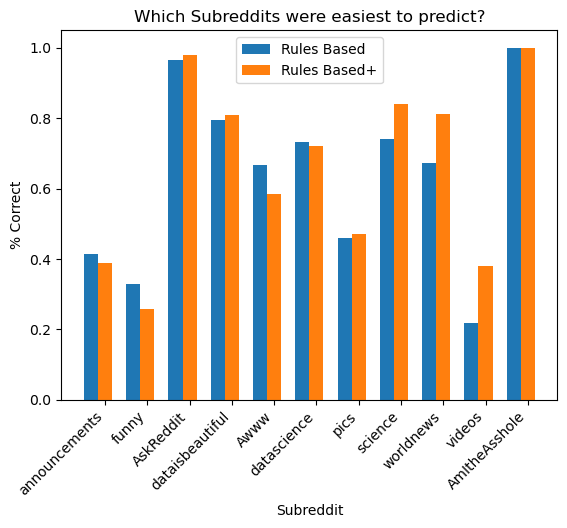

In [373]:
obj.compare(['Rules Based', 'Rules Based+'])

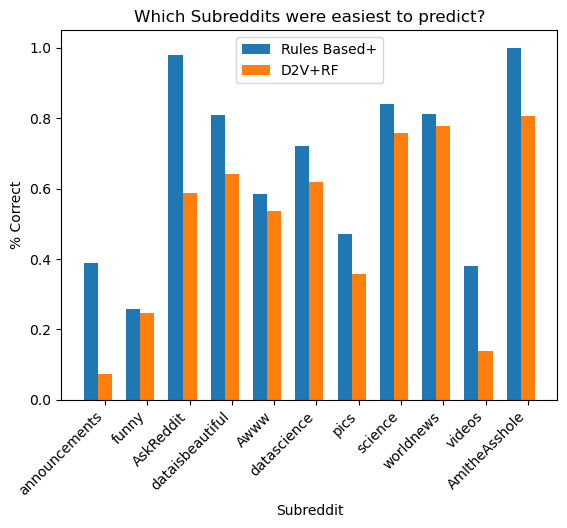

In [374]:
obj.compare(['Rules Based+', 'D2V+RF'])

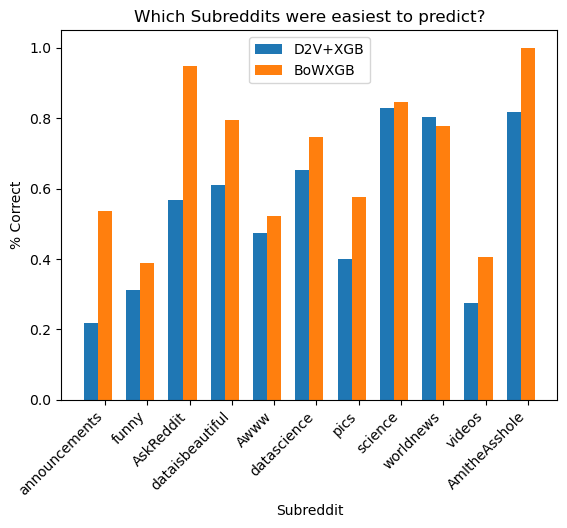

In [388]:
obj.compare(['D2V+XGB', 'BoWXGB'])

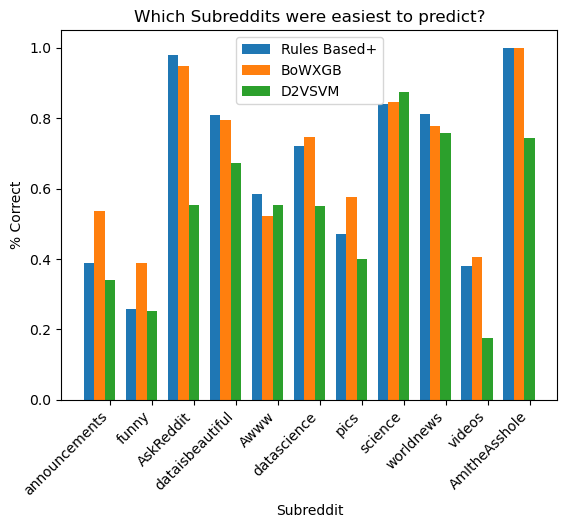

In [389]:
obj.compare([ 'Rules Based+', 'BoWXGB', 'D2VSVM' ])

## Discussion

Surprizingly, Bag-of-Words embeddings were far superior to more the sophisticated Doc2Vec embeddings. This is most likely due to the following reasons:
- BoW had ~14,000 features while D2V had 100
- D2V is much more effective with a larger corpus

XGBoost preformed comparable to Random Forrest, with a slight advantage over Random Forrest for more difficult categories such as r/announcements and r/funny.

The presence of the addtional information about the length of a post helped mostly in r/worldnews, r/science, and r/videos. This was to be expected after viewing the graphs from the Analyzing the Data phase.

## Proposal

Create 3 new embeddings, each with exactly 1000 features. 1 with 1000 most important BoW features, 1 with 1000 D2V, and 1 with 500 of each. Use this on XGBoost and see which preforms best.

In addition, I should create some auxillary embedding information to help with the poorer preforming subreddits. The inclusion of emojis will certainly help. As will question marks and a few other punctuation.

Idea Auxillary information:
- title length
- contains the word 'reddit' as a substring
- number of emojis
- number of each punctuation
- number of capital letters?
- sentiment?
- number of words from each part of speech
- topic?

In [404]:
df_raw[df_raw['subreddit'] == 'funny']

,id,title,subreddit
166,10gg34f,My watch is going insane [OC],funny
167,10gg044,This restaurant has had it with the missing gl...,funny
168,10gft2i,let’s see if anyone gets this,funny
169,10gfs2x,He’s a hero,funny
170,10gfp1i,Today’s fortune cookie says,funny
...,...,...,...
1017,10anc80,the cream in my coffee,funny
1018,10anbf3,Why has thou forsaken me,funny
1019,10amv44,Australian cricketer Scott Boland falling prey...,funny
1020,10amttk,Why would you eat the wrapper?,funny


In [405]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Create a list of sentences
sentences = ["This is a positive sentence.", "This is a negative sentence.", "This sentence is neutral."]

# Iterate over the sentences and get the sentiment scores
for sentence in sentences:
    sentiment = sia.polarity_scores(sentence)
    print(sentence)
    print(sentiment)


This is a positive sentence.
{'neg': 0.0, 'neu': 0.29, 'pos': 0.71, 'compound': 0.5994}
This is a negative sentence.
{'neg': 0.529, 'neu': 0.286, 'pos': 0.186, 'compound': -0.5267}
This sentence is neutral.
{'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'compound': 0.0772}


In [ ]:
dic = {'a':1, 'b':2, 'c':3}
dic = {key:dic[key] for key in ['a','b']}
dic

In [420]:
import nltk
import pandas as pd
from nltk import pos_tag
from nltk.tokenize import word_tokenize

def count_pos(sentences):
    # Create a dictionary to store the POS counts
    pos_counts = {'CC': 0, 'CD': 0, 'DT': 0, 'EX': 0, 'FW': 0, 'IN': 0, 'JJ': 0, 'JJR': 0, 'JJS': 0, 'LS': 0, 'MD': 0, 'NN': 0, 'NNS': 0, 'NNP': 0, 'NNPS': 0, 'PDT': 0, 'POS': 0, 'PRP': 0, 'PRP$': 0, 'RB': 0, 'RBR': 0, 'RBS': 0, 'RP': 0, 'SYM': 0, 'TO': 0, 'UH': 0, 'VB': 0, 'VBD': 0, 'VBG': 0, 'VBN': 0, 'VBP': 0, 'VBZ': 0, 'WDT': 0, 'WP': 0, 'WP$': 0, 'WRB': 0}

    # Iterate over the sentences
    for sentence in sentences:
        # Tokenize and POS tag the sentence
        tagged_tokens = pos_tag(word_tokenize(sentence))

        # Iterate over the tagged tokens
        for token in tagged_tokens:
            # If the POS is in the dictionary, increment the count
            if token[1] in pos_counts:
                pos_counts[token[1]] += 1

    # Create a DataFrame from the POS counts dictionary
    pos_df = pd.DataFrame(pos_counts, index=[0])

    return pos_df


In [422]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\raino\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [424]:
import pandas as pd

# Create a sample pandas Series
sentences = pd.Series(["This is a positive sentence.", "This is a negative sentence.", "This sentence is neutral."])

# Pass the Series to the count_pos function
pos_df = count_pos(sentences)

pos_df


,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,0,0,5,0,0,0,3,0,0,0,...,0,0,0,0,0,3,0,0,0,0


In [ ]:


temp_X_train = obj.Feature_Vectors['D2V+'].loc[obj._train_index]
temp_Y_train = obj.Y_train

temp_model = _XGBoost_train(temp_X_train, temp_Y_train)
#temp_predictions = _SVM_predict(temp_X_test, temp_model)
#temp_predictions

In [ ]:
temp_title_vectors = obj.Feature_Vectors['D2V+'].loc[obj._test_index]

temp_predictions = _XGBoost_predict(temp_title_vectors, temp_model)
temp_predictions

In [ ]:
obj.Feature_Vectors['D2V']

In [ ]:
obj.full_data

In [ ]:

"""
def more_than_120(sentence):
    return (len(sentence)>120)

def less_than_25(sentence):
    return (len(sentence)<25)


def has_chinese_characters(sentence):
    # Use regular expression to match any Chinese characters
    chinese_characters_pattern = re.compile(r"[\u4e00-\u9fa5]+")
    if chinese_characters_pattern.search(sentence):
        return True
    else:
        return False

def has_special_characters(sentence):
    # Use regular expression to match any characters that are not latin alpha numeric, punctuation, emojis, or special symbols
    special_characters_pattern = re.compile(r"[^\w\s~!@#$%^&*()_\u263a-\U0001f645\u2600-\u26ff\u2700-\u27bf]+")
    if special_characters_pattern.search(sentence):
        return True
    else:
        return False
"""

#conditions['is long'] = more_than_120
#conditions['has chinese'] = has_chinese_characters
#conditions['is short'] = less_than_25
#conditions['has special characters'] = has_special_characters

In [ ]:

def has_special_characters(sentence):
    std_american_keyboard_chars = r"\"!#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~"
    special_characters_pattern = re.compile(f"[^{std_american_keyboard_chars}\u263a-\U0001f645\u2600-\u26ff\u2700-\u27bf]+")
    if special_characters_pattern.search(sentence):
        return True
    else:
        return False


df[df['title'].apply(has_special_characters)]



In [ ]:
# test sentences
sentences = [
    "I love 🍕 pizza! 🍕",  # False
    "I love pizza! 🍕", # False
    "I love pizza! 🍕🍕🍕", # False
    "I love 🍕 pizza! 🍕🍕🍕", # False
    "I løve אַַ pizza! 🍕", # True
    "I løve אַַ🍕 pizza! 🍕🍕🍕", # True
    "I løve 🍕 pi🍕za! אַַ🍕🍕🍕", # True
    "I løve 🍕 pi🍕za! אַַ🍕🍕🍕🍕", # True
    "I løve 🍕 pi🍕za! אַַ🍕🍕🍕🍕🍕", # True
    "I løve 🍕 pi🍕za! אַַ🍕🍕🍕🍕🍕🍕", #True
]

# test the function on each sentence
for sentence in sentences:
    print(f"{sentence}: {has_special_characters(sentence)}")


In [ ]:
sentence = "I love pizza, 🍕"
print(has_special_characters(sentence)) # False


In [ ]:
table = pd.DataFrame(columns=['Condition', '% Correct', 'Total Affected'])


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Initialize an empty dictionary to store the data
data = {}

# Iterate over the top_subreddits
for subreddit in top_subreddits:
    # Get the titles for the subreddit
    titles = df_raw[df_raw['subreddit'] == subreddit]['title']
    # Get the number of non-alpha-numeric characters in the titles
    num_nonalphanumeric = [len(re.findall('[^A-Za-z0-9]+', title)) for title in titles]
    # Get the percentage of titles for the subreddit with a specific number of non-alpha-numeric characters
    percentages = []
    for i in range(max(num_nonalphanumeric)):
        percentages.append(num_nonalphanumeric.count(i)/len(num_nonalphanumeric))
    # Add the data to the dictionary
    data[subreddit] = percentages

# Plot the data
for subreddit, percentages in data.items():
    plt.plot(range(len(percentages)), percentages, label=subreddit)

# Add labels and title
plt.xlabel("Number of non-alpha-numeric characters")
plt.ylabel("Percentage of titles")
plt.title("Percentage of titles by number of non-alpha-numeric characters and subreddit")
plt.legend()

# Show
plt.show()


In [ ]:
pip install emoji

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import emoji

# Initialize an empty dictionary to store the data
data = {}

# Iterate over the top_subreddits
for subreddit in top_subreddits:
    # Get the titles for the subreddit
    titles = df_raw[df_raw['subreddit'] == subreddit]['title']
    # Get the number of emojis in the titles
    num_emojis = [len(emoji.emojize(title)) for title in titles]
    # Get the percentage of titles for the subreddit with a specific number of emojis
    percentages = []
    for i in range(max(num_emojis)):
        percentages.append(num_emojis.count(i)/len(num_emojis))
    # Add the data to the dictionary
    data[subreddit] = percentages

# Plot the data
for subreddit, percentages in data.items():
    plt.plot(range(len(percentages)), percentages, label=subreddit)

# Add labels and title
plt.xlabel("Number of emojis")
plt.ylabel("Percentage of titles")
plt.title("Percentage of titles by number of emojis and subreddit")
plt.legend()

# Show
plt.show()

In [ ]:
import re

def has_emoji(sentence):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64f"  # emoticons
                               u"\U0001F300-\U0001F5ff"  # symbols & pictographs
                               u"\U0001F680-\U0001F6ff"  # transport & map symbols
                               u"\U0001F1e0-\U0001F1ff"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.search(sentence) is not None


In [326]:
sentence = "I love pizza 🍕"
print(sentence.lower()) # True


i love pizza 🍕


In [ ]:
list(map(has_emoji, ["hello world :D ! ","I love pizza 🍕", "!@#$%^&*()_+1234567890-=" ]))

In [431]:
import re

def filter_emoji(df):
    # Create a regular expression pattern to match emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    # Use the 'apply' method to apply the regular expression search to the 'title' column
    df['emoji_in_title'] = df['title'].apply(lambda x: bool(emoji_pattern.search(x)))
    df = df[df.emoji_in_title == True]
    return df


filter_emoji(df_raw)

,title,subreddit,emoji_in_title
id,,,
10fwpud,Dude that looks like Patrick Beverly playing h...,funny,True
10ftbli,My schools cooking class has two groups. You c...,funny,True
10fresi,Forgot the old man was fishin and about had a ...,funny,True
10fepbx,I put a spell on you…cause you’re mine 🎶,funny,True
10ez0le,Who else has THAT friend? Can’t go no where wi...,funny,True
...,...,...,...
10ez54e,Using ai to write viral TikToks 😂,videos,True
10evz2c,Harry Pinero is so smooth👏🏼😭,videos,True
10evbk4,Trees of beautiful British Columbia 🌲,videos,True


In [439]:
df_raw

,title,subreddit,emoji_in_title
id,,,
t93ec3,This subreddit is closed for new posts and com...,announcements,False
pg006s,COVID denialism and policy clarifications,announcements,False
pbmy5y,"Debate, dissent, and protest on Reddit",announcements,False
nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements,False
mi01fg,Second,announcements,False
...,...,...,...
10ds6b2,WIBTA if I lied to my husband about not keepin...,AmItheAsshole,False
10ds0k3,AITA for refusing to work?,AmItheAsshole,False
10drxdx,"AITA for ""not wanting"" to sit next to my best ...",AmItheAsshole,False


In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a list of documents as input for the CountVectorizer
documents = ["this, is a test", "this is 🍕 pizza piZZa another 'test'", "This is yet another test!"]

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the vectorizer on the documents
X = vectorizer.fit_transform(documents)

# Get the feature names
features = vectorizer.get_feature_names()
print("Feature names:", features)

# Get the feature vectors
vectors = X.toarray()
print("Feature vectors:", vectors)


Feature names: ['another', 'is', 'pizza', 'test', 'this', 'yet']
Feature vectors: [[0 1 0 1 1 0]
 [1 1 2 1 1 0]
 [1 1 0 1 1 1]]


C:\Users\raino\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer

# Create a list of documents as input for the CountVectorizer
documents = ["this, is a test", "this is 🍕 pizza piZZa another 'test'", "This is yet another test!"]

# Use Gensim to tag the documents
tagged_documents = [simple_preprocess(doc) for doc in documents]

# Initialize the CountVectorizer
vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)

# Fit and transform the vectorizer on the tagged documents
X = vectorizer.fit_transform(tagged_documents)

# Get the feature names
features = vectorizer.get_feature_names()
print("Feature names:", features)

# Get the feature vectors
vectors = X.toarray()
print("Feature vectors:", vectors)


Feature names: ['another', 'is', 'pizza', 'test', 'this', 'yet']
Feature vectors: [[0 1 0 1 1 0]
 [1 1 2 1 1 0]
 [1 1 0 1 1 1]]


In [9]:
tagged_documents

[['this', 'is', 'test'],
 ['this', 'is', 'pizza', 'pizza', 'another', 'test'],
 ['this', 'is', 'yet', 'another', 'test']]

In [20]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

# Create a list of documents as input for the CountVectorizer
documents = ["[oc] this, is a test", "(oc) this is 🍕 __emoji__ pizza piZZa another: 'test'", 'This is yet another "test"!']

# Use NLTK to tag the documents
tagged_documents = [nltk.pos_tag(nltk.word_tokenize(doc)) for doc in documents]

# Initialize the CountVectorizer
vectorizer = CountVectorizer(tokenizer=lambda doc: [(word,  tag) for word, tag in doc], lowercase=False)

# Fit and transform the vectorizer on the tagged documents
X = vectorizer.fit_transform(tagged_documents)

# Get the feature names
features = vectorizer.get_feature_names()
print("Feature names:", features)

# Get the feature vectors
vectors = X.toarray()
print("Feature vectors:", vectors)


Feature names: [('!', '.'), ("'", "''"), ("''", "''"), ("'test", 'JJS'), ('(', '('), (')', ')'), (',', ','), (':', ':'), ('This', 'DT'), ('[', 'JJ'), (']', 'NN'), ('__emoji__', 'NNP'), ('``', '``'), ('a', 'DT'), ('another', 'DT'), ('is', 'VBZ'), ('oc', 'NN'), ('piZZa', 'NN'), ('pizza', 'NN'), ('test', 'NN'), ('this', 'DT'), ('yet', 'RB'), ('🍕', 'JJ')]
Feature vectors: [[0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0]
 [0 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1]
 [1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0]]


In [16]:
tagged_documents

[[('[', 'JJ'),
  ('oc', 'NN'),
  (']', 'NN'),
  ('this', 'DT'),
  (',', ','),
  ('is', 'VBZ'),
  ('a', 'DT'),
  ('test', 'NN')],
 [('(', '('),
  ('oc', 'NN'),
  (')', ')'),
  ('this', 'DT'),
  ('is', 'VBZ'),
  ('🍕', 'JJ'),
  ('pizza', 'NN'),
  ('piZZa', 'NN'),
  ('another', 'DT'),
  ("'test", 'JJS'),
  ("'", "''")],
 [('This', 'DT'),
  ('is', 'VBZ'),
  ('yet', 'RB'),
  ('another', 'DT'),
  ('``', '``'),
  ('test', 'NN'),
  ("''", "''"),
  ('!', '.')]]

In [26]:
df_raw

,title,subreddit
id,,
t93ec3,This subreddit is closed for new posts and com...,announcements
pg006s,COVID denialism and policy clarifications,announcements
pbmy5y,"Debate, dissent, and protest on Reddit",announcements
nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements
mi01fg,Second,announcements
...,...,...
10f99lt,AITA for exposing what was told to me in confi...,AmItheAsshole
10f942p,AITA for getting cosmetic surgery while my sis...,AmItheAsshole
10f8zxj,AITA for refusing to take my wife to work,AmItheAsshole


In [40]:
# Create an empty list to store the posts
posts_new = []

# Iterate through the subreddits and get the last 1000 posts from each
for sub in ['all']:
    subreddit_posts = reddit.subreddit(sub).hot(limit=10000)
    for post in subreddit_posts:
        posts_new.append(post)

# Create a list of dictionaries containing the data for each post
data_new = [{'id': post.id, 'title': post.title, 'subreddit': post.subreddit.display_name} for post in posts_new]

# Create a Pandas dataframe from the list of dictionaries
df_raw_new = pd.DataFrame(data_new)
df_raw_new = df_raw_new.set_index('id')
df_raw_new

,title,subreddit
id,,
10hxsh0,[OC] Sarge?!,comics
10hvpgm,My stealth bomber,aww
10hvjxw,Overly excited pomeranian does agility,nextfuckinglevel
10hwvv6,Group of Tulsa high schoolers ditched class to...,pics
10hv8d8,Some French comedians made a video about it's ...,funny
...,...,...
10hydyr,Eggs baby,memes
10i0aw0,Divide and conquer,memes
10hxv8z,once i get friends,memes


In [31]:
len(data_new)

846

In [35]:
df_raw_new = pd.DataFrame(data_new)
df_raw_new = df_raw_new.set_index('id')
df_raw_new

,title,subreddit
id,,
10i26p0,Laundry Machine laying sick beats for Mos Def ...,funny
10i24jp,Jeff Bezos life story (parody),funny
10i24d0,These optional upcharges at the bar’s discretion,funny
10i1u7z,How my 4-year-old ate her pizza for lunch today.,funny
10i1poo,What’s the deal with Alpha and Beta Males? Scr...,funny
...,...,...
10cchfa,"""I just followed the designs""",funny
10cbgnh,Found this in some old pics of my parents wedding,funny
10cbd6u,What am I supposed to be doing?,funny


In [54]:
len("is 🍕 pizza")

10